<hr style="height: 1px;">
<i>This notebook was authored by the 8.S50x Course Team, Copyright 2022 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

<h1>Project 1: Detecting Gravitational-Waves from Binary Black Hole Merger 
with LIGO Open Data</h1>


<a name='section_1_0'></a>
<hr style="height: 1px;">


## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">PROJ1.0 Overview</h2>


<h3>Navigation</h3>

<table style="width:100%">
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_1_1">PROJ1.1 Experiment with GW-tools</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_1_1">PROJ1.1 Checkpoints</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_1_2">PROJ1.2 Filters on LIGO Data</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_1_2">PROJ1.2 Checkpoints</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_1_3">PROJ1.3 Analytic Model Part I - Frequency vs. Time</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_1_3">PROJ1.3 Checkpoints</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_1_4">PROJ1.4 Analytic Model Part I - Strain vs. Time</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_1_4">PROJ1.4 Checkpoints</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_1_5">PROJ1.5 Search for Signal in Long Time Range</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_1_5">PROJ1.5 Checkpoints</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_1_6">PROJ1.6 Exploring Correlation and Time-Delay between Detectors</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_1_6">PROJ1.6 Checkpoints</a></td>
    </tr>
</table>



<h3>Learning Objectives</h3>

In this project we will explore the following objectives:

- Commonly-used data analysis packages 
- Transformations and filters (fourier, PSD, whitening, etc.)
- Creating and fitting functions to data 
- Extrapolating parameters from functional fits
- Searches for signals in large datasets


<h3>Introduction to Gravitational-Waves</h3>

The existence of gravitational waves (GW) was first predicted by Albert Einstein in his General Theory of Relativity in 1916. He found that the linearized weak-field equations had wave solutions. By analogy to electromagnetism, time variation of the mass quadrupole moment of the source is expected to lead to transverse waves of spatial strain. The existence of GW was first demonstrated in 1974 by the discovery of a binary system composed of a pulsar in orbit around a neutron star by Hulse and Taylor [[1]](https://ui.adsabs.harvard.edu/abs/1975ApJ...195L..51H/abstract). However, direct detections of GW did not arrive until 2016. In that year, The LIGO (The Laser Interferometer Gravitational-Wave Observatory) collaboration reported the first direct detection of GW from a binary black hole system merging to form a single black hole [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102). The observations reported in this paper and futher GW detections wprovide new tests of generay relativity in its strong-field regime, and GW observations have become an important new means to learn about the Universe.

In this project, you will reproduce the results reported in [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102) with LIGO open data. This tutorial will show how to analyze a particular GW event GW150914 (the first GW ever detected). In the tutorial, you will find how to download the data collected by Handford Observatory starting from Mon Sep 14 09:16:37 GMT 2015, plot the strain, whiten and filter the strain, plot a q-transform of the data, and extract the features of the source with a simple analytic model. After getting familiar with the basic analysis methods, you need to explore more events, check the consistence between detectors, match numerical relativity waveform template to extract accurate information of the source, compare with LIGO published results, and develop a machinery to search GW event within a long time range.

<h3>Importing Libraries</h3>

First, let's install the correct version of matplotlib for our packages. 

**If you are using Google Colab**: This install will require you to restart the runtime because colab has a different version of matplotlib installed. Run the cell below and then click "RESTART RUNTIME" or go to Runtime -> Restart runtime. Then, run the cell again and continue on. 

**If you are using standalone Jupyter Notebook**: This step should run without problem and will install matplotlib=3.3.0 onto the python kernel that jupyter is using. 

In [ ]:
#>>>RUN

!pip install matplotlib==3.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Run the cell below to install and import the relevant libraries for this notebook. Optionally, set the plot resolution and default figure size.

In [ ]:
#>>>RUN

# pip will install the packages if they aren't availiable on your environment
!pip install gwpy numpy scipy h5py wget lmfit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#>>>RUN

# Import the packages you will need for the project
import numpy as np
import math
from gwpy.timeseries import TimeSeries
from scipy.linalg import fractional_matrix_power
from scipy.stats import zscore

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py

import wget
import os 

import lmfit
from lmfit import Model, minimize, fit_report, Parameters

#set plot resolution
%config InlineBackend.figure_format = 'retina'

#set default figure size
plt.rcParams['figure.figsize'] = (9,6)

<a name='section_1_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">PROJ1.1 Experiment with GW-tools</h2>    

| [Top](#section_1_0) | [Previous Section](#section_1_0) | [Checkpoints](#problems_1_1) | [Next Section](#section_1_2) |


<h3>Downloading and Plotting the Time Series Data</h3>

In this section, we will load in a GW and experiment with different methods to visualize it. First, we'll **take a look at the 32 seconds of raw time-series data** but will quickly see that a signal is almost impossible to distinguish from this the raw data due to LIGO detector noise. We will apply a transformation in order to see where this noise is originating from. 

First download the data. Then make a plot of strain vs. time. Run the cells below. Source and attribution information is found below.

NOTE: Recently Gravitational Wave Open Science Center servers have been unreliable. If you try to download data during a server downtime, you might get an error. If this occurs, uncomment the bottom `wget` command. 

In [ ]:
# Download the corresponding dataset
import wget
import os 

try: 
    os.mkdir('PROJ1') 
except OSError as error: 
    print(error)

wget.download('https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5', 'PROJ1')

# If the above command doesn't work because GW-OSC is down uncomment this line:
# wget.download("https://www.dropbox.com/s/ii8jf1rck14pplr/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5?dl=1", 'PROJ1/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5')
# This is just a dropbox link to the same dataset

[Errno 17] File exists: 'PROJ1'


'PROJ1/H-H1_GWOSC_4KHZ_R1-1126257415-4096 (1).hdf5'

>**data:** H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5 <br>
>**source:** https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/ <br>
>**attribution:** R. Abbott et al. (LIGO Scientific Collaboration and Virgo Collaboration), "Open data from the first and second observing runs of Advanced LIGO and Advanced Virgo", SoftwareX 13 (2021) 100658. <br>
>**use statement:** "This research has made use of data or software obtained from the Gravitational Wave Open Science Center (gw-openscience.org), a service of LIGO Laboratory, the LIGO Scientific Collaboration, the Virgo Collaboration, and KAGRA. LIGO Laboratory and Advanced LIGO are funded by the United States National Science Foundation (NSF) as well as the Science and Technology Facilities Council (STFC) of the United Kingdom, the Max-Planck-Society (MPS), and the State of Niedersachsen/Germany for support of the construction of Advanced LIGO and construction and operation of the GEO600 detector. Additional support for Advanced LIGO was provided by the Australian Research Council. Virgo is funded, through the European Gravitational Observatory (EGO), by the French Centre National de Recherche Scientifique (CNRS), the Italian Istituto Nazionale di Fisica Nucleare (INFN) and the Dutch Nikhef, with contributions by institutions from Belgium, Germany, Greece, Hungary, Ireland, Japan, Monaco, Poland, Portugal, Spain. KAGRA is supported by Ministry of Education, Culture, Sports, Science and Technology (MEXT), Japan Society for the Promotion of Science (JSPS) in Japan; National Research Foundation (NRF) and Ministry of Science and ICT (MSIT) in Korea; Academia Sinica (AS) and National Science and Technology Council (NSTC) in Taiwan."   

<Figure size 648x432 with 0 Axes>

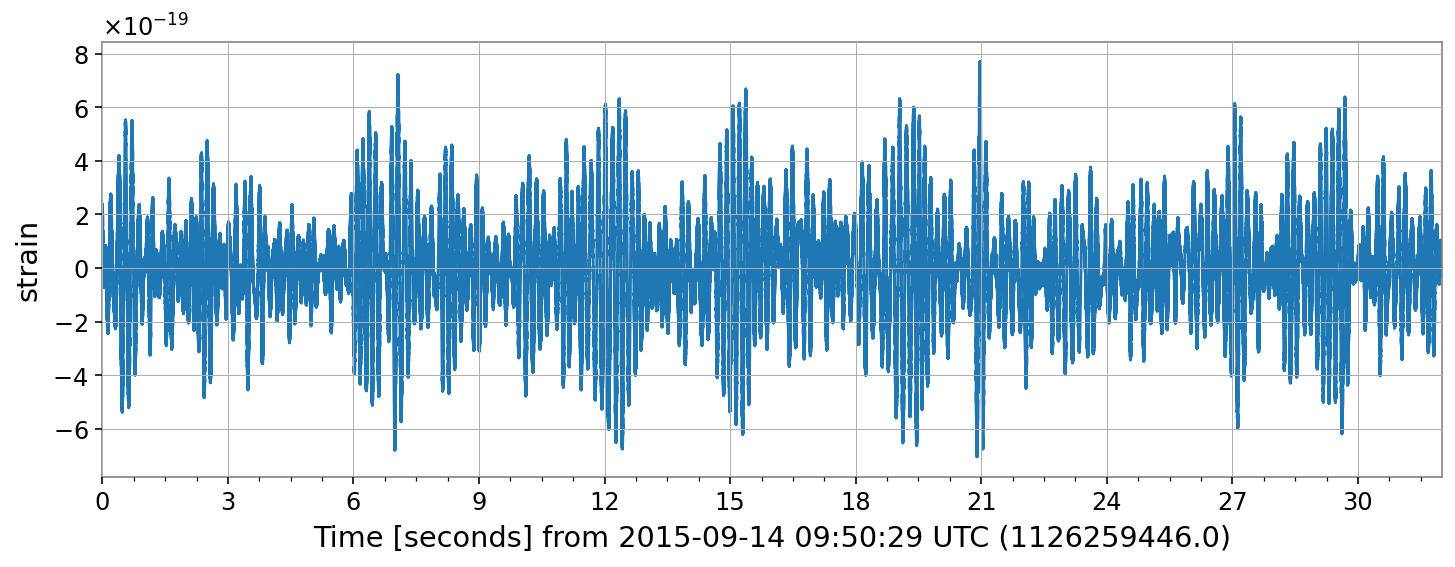

In [ ]:
# Set parameters
fn = 'PROJ1/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5' # data file
tevent = 1126259462.422 # GPS time (continuous time scale from Jan 1980)
evtname = 'GW150914' # event name
detector = 'H1' # detector: L1 or H1

# Load LIGO data and crop 16 seconds before and 16 seconds after the event
strain = TimeSeries.read(fn, format='hdf5.gwosc')
center = int(tevent)
strain = strain.crop(center-16, center+16)

# Show the LIGO strain vs. time
plt.figure()
strain.plot()
plt.ylabel('strain')
plt.show()

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 1.1.1</span>

Carefully read the plot of LIGO strain vs. time to understand the axes.

What day of the week (in UTC time-zone) was the GW observation made?

Hint: The plotting API includes this information. 

We can see that the signal (occuring at 16 seconds) in the above figure, is almost impossible to see. In fact, it is **lower** magnitude than the rest of the time-series - this is because LIGO data is dominated by low frequency noise! Let's take a look at exactly where the this noise is coming from. 

<h3>Plotting in the Frequency Domain</h3>

Plotting these data in the Fourier domain gives us an idea of the frequency content of the data. A way to visualize the frequency content of the data is to plot the amplitude spectral density, ASD. The ASDs are the square root of the power spectral densities (PSDs), which are **averages of the square of the fast fourier transforms (FFTs)** of the data. They are an estimate of the "strain-equivalent noise" of the detectors versus frequency, which limit the ability of the detectors to identify GW signals.

Run the following code to plot the ASD vs. frequency.

<Figure size 648x432 with 0 Axes>

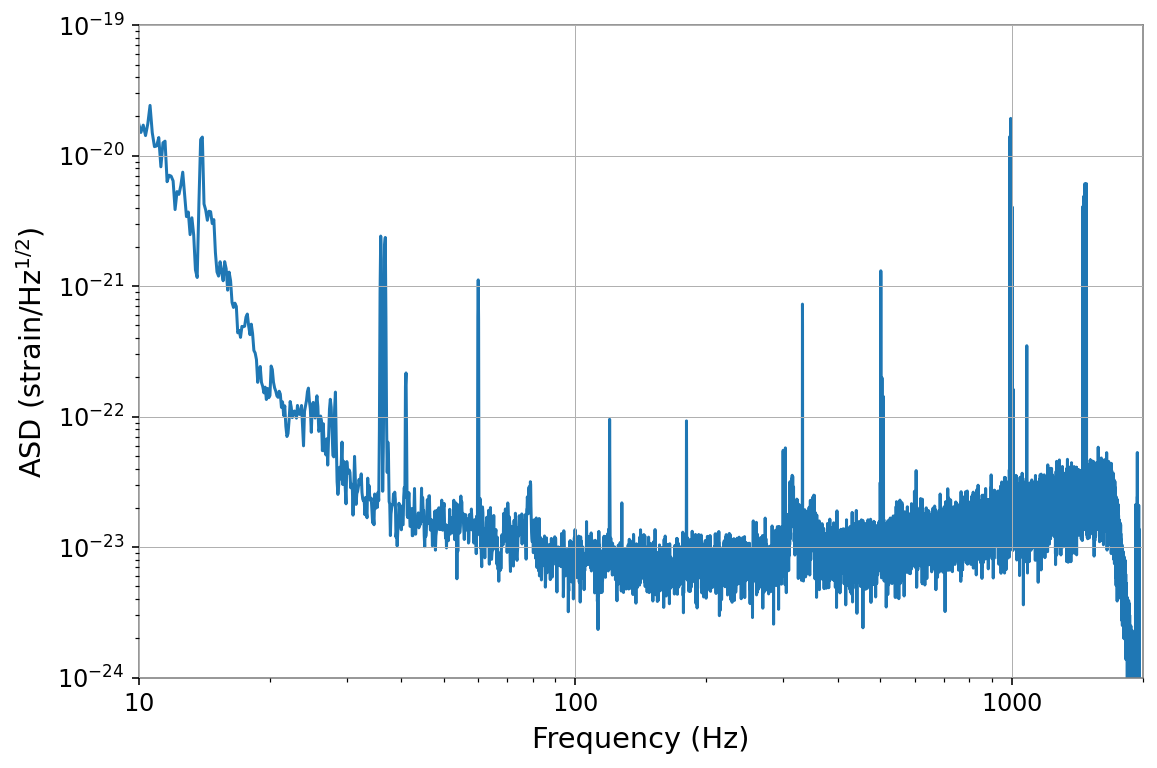

In [ ]:
#>>>RUN

# Plot the amplitude spectrum density (ASD)

# ASD be created by the built in ASD function in GWpy
asd = strain.asd(fftlength=8)

plt.clf()
asd.plot()
plt.xlim(10, 2000)
plt.ylim(1e-24, 1e-19)
plt.ylabel('ASD (strain/Hz$^{1/2})$')
plt.xlabel('Frequency (Hz)')
plt.show()

You can see strong spectral lines in the data - corresponding to large power sources at the corresponding frequencies. They are all of instrumental origin. Some are engineered into the detectors (mirror suspension resonances at ~500 Hz and harmonics, calibration lines, control dither lines, etc) and some (60 Hz and harmonics) are unwanted. We'll return to these, later.

You can't see the signal in this plot, since it is relatively weak and less than a second long, while this plot averages over 32 seconds of data. So this plot is entirely dominated by instrumental noise.


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 1.1.2</span>

Above 20 Hz, at what frequency (to the nearest 100 Hz) does the largest spectral-line amplitude noise occur on the LIGO detector? Enter your answer as number with precision 1e2.

Hint: Look more closely at the data by changing your `(x,y)` limits.

In [13]:
#>>>PROBLEM
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

asd = strain.asd(fftlength=8)

x_min = #YOUR CODE HERE
x_max = #YOUR CODE HERE
y_min = #YOUR CODE HERE
y_max = #YOUR CODE HERE

plt.clf()
asd.plot()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.ylabel('ASD (strain/Hz$^{1/2})$')
plt.xlabel('Frequency (Hz)')
plt.show()

>#### Follow-up 1.1.2a (ungraded)
>
>What are the largest sources of noise in the signal? Can you identify them?

<a name='section_1_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">PROJ1.2 Filters on LIGO Data</h2>    

| [Top](#section_1_0) | [Previous Section](#section_1_1) | [Checkpoints](#problems_1_2) | [Next Section](#section_1_3) |

<h3>Overview</h3>

In this section, we will continue working with the LIGO data we just loaded in. However, now we will **apply filters in order to clean up the data**. Filters can be applied in a variety of different physics applications to remove unwanted dependencies in your data. For time-series we will use the whitening and bandpass filters. 


<h3>Whitening</h3>

From the ASD above, we can see that noise fluctuations are much larger at low and high frequencies and near spectral lines. 

We can "whiten" the data, suppressing the extra noise at low frequencies and at the spectral lines, to better see the weak signals in the most sensitive band. This is done by normalizing the power at all frequencies so that excess power at any frequency is more obvious. The whitening transformation is well explained here [[3]](https://courses.media.mit.edu/2010fall/mas622j/whiten.pdf). With timeseries, there is a shortcut - taking the ifft(fft/asd)! This is implemented below.


In [14]:
#>>>RUN

def rough_whitener(strain_data, crop_window=30): 
  asd_data = strain_data.asd()
  fft_data = strain_data.fft()
  whitened = np.fft.irfft(np.abs(1/asd_data)*fft_data)
  return whitened

whitened_timeseries = TimeSeries(rough_whitener(strain))
whitened_timeseries.t0 = tevent - 16 # defining start time for plot
whitened_timeseries.dt = 1/4096 # defining timestep at 4096 Hz
plt.clf()
whitened_timeseries[0:-1].plot() # you can plot different steps of time here
plt.ylabel('strain (whitened)')
plt.title('Roughly Whitened Data')
plt.show()

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 1.2.1</span>

Look very closely at the "Roughly Whitened Data" plot. What unwanted effect did the transform produce? Keep in mind that we want data to be normalized by the ASD. 

Hint: If needed, you can look around by plotting different parts of the timeseries. 


      A. The transform has not normalized the data. 
      B. The time on the plot is wrong. 
      C. The transform has not removed noise and there are spikes everywhere. 
      D. There are edge effects that look wrong at the very beginning and very end. 





<h3>Removing Artifacts</h3>

The GWpy whitener [[4]](https://github.com/gwpy/gwpy/blob/master/gwpy/timeseries/timeseries.py#L1657-L1752) does some additional fancy time-series operations, including fixing the edge effects of the rough whitener using a window function [[5]](https://en.wikipedia.org/wiki/Window_function), so we will use that included function. 

<Figure size 648x432 with 0 Axes>

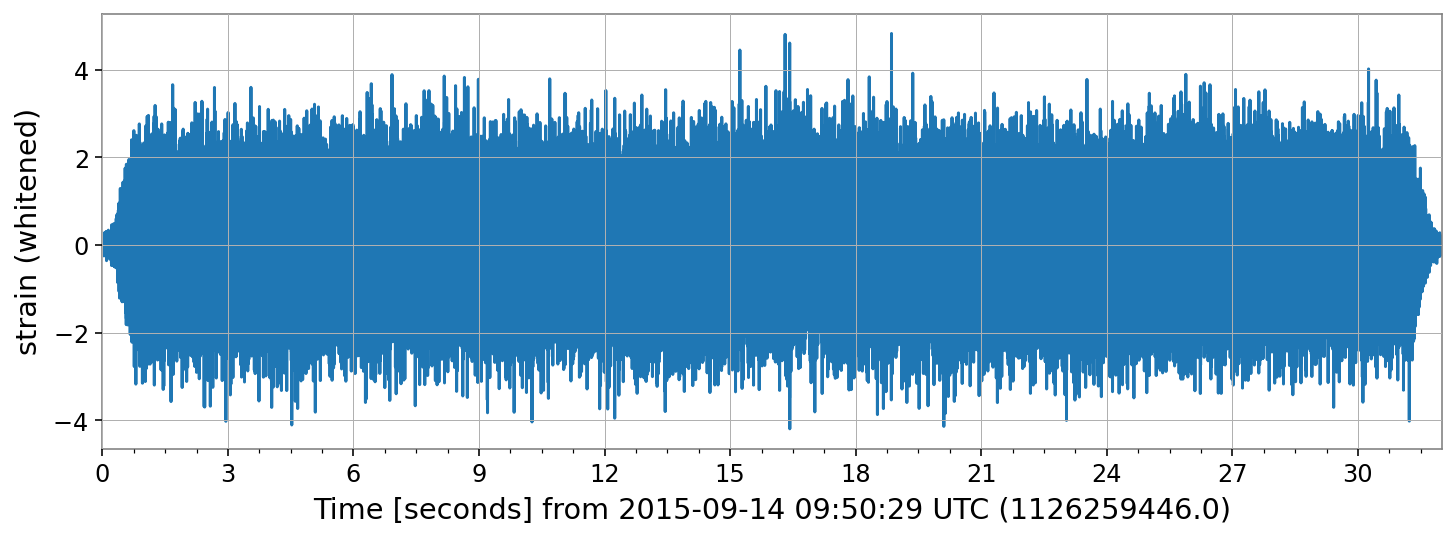

In [ ]:
#>>>RUN

# Whitening data using GWpy 

white_data = strain.whiten() #We will just use the GWpy whitening function here
plt.clf()
white_data.plot()
plt.ylabel('strain (whitened)')
plt.show()

Now we are starting to see some signal around 16 seconds! It's still not good enough, so we will apply a band-pass filter to reject high frequency noise. But first, lets check out the Q-tranform to see what frequency ranges contain our GW. 

<h3>Q-Transform</h3>

To see where in the frequency spectrum of our signal lies (and see what range to bandpass on), we take a q-transform of the data and check the time variation of frequency. This q-transform is formed by taking the magnitude of the Short-time Fourier transform [[5]](https://en.wikipedia.org/wiki/Short-time_Fourier_transform), normally on a log-intensity axis (e.g. Energy).

NOTE: Can we have a part where we take the Q-transform at certain time slices and ask which one might have the GW signal?

<Figure size 648x432 with 0 Axes>

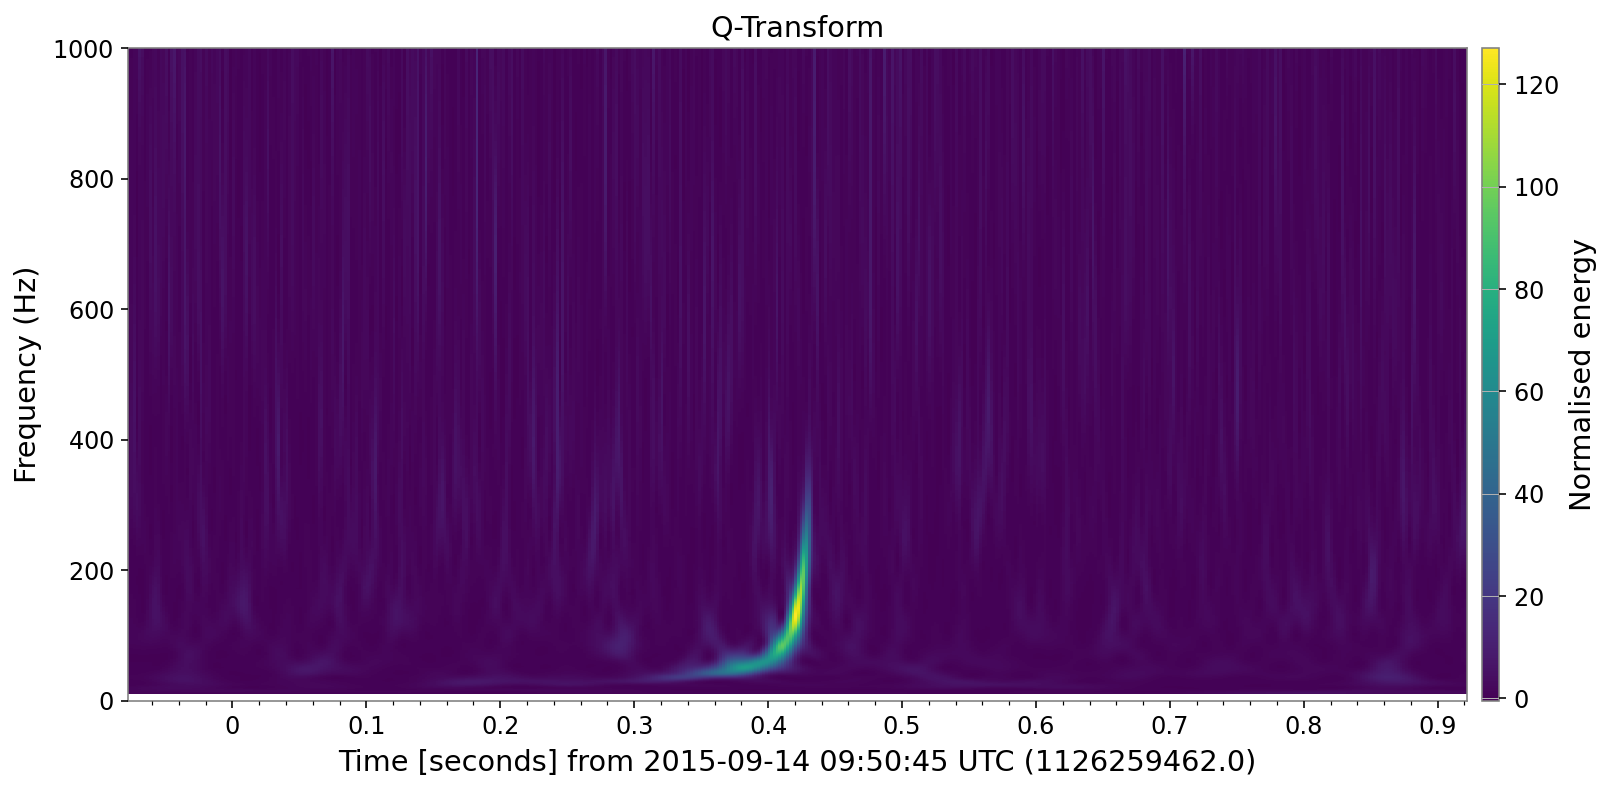

In [ ]:
#>>>RUN

dt = 1  #-- Set width of q-transform plot, in seconds
hq = strain.q_transform(outseg=(tevent-dt, tevent+dt))

plt.clf()
fig = hq.plot()
ax = fig.gca()
fig.colorbar(label="Normalised energy")
ax.grid(False)
plt.xlim(tevent-0.5, tevent+0.5)
plt.ylim(0, 1000)
plt.ylabel('Frequency (Hz)')
plt.title('Q-Transform')
plt.show()

<h3>Bandpassing</h3>

A bandpass filter can select data from a specific range of frequencies and is used in a wide variety of physics applications. The code below shows you a framework to do bandpassing within GWpy. This will **select data with frequencies above bandpass_low and below bandpass_high**.

Below is defined a function that will plot the timeseries and ASD after applying a bandpass filter range. At first, a bandpass of `[1,1000]` is chosen, which essentially leaves the data unchanged. The plots are as follows:
- the whitened time series data after applying the bandpass
- a 0.3 second window of the whitened time series data, centered around the known event
- the ASD of the unwhitened data, after applying the bandpass

<Figure size 648x432 with 0 Axes>

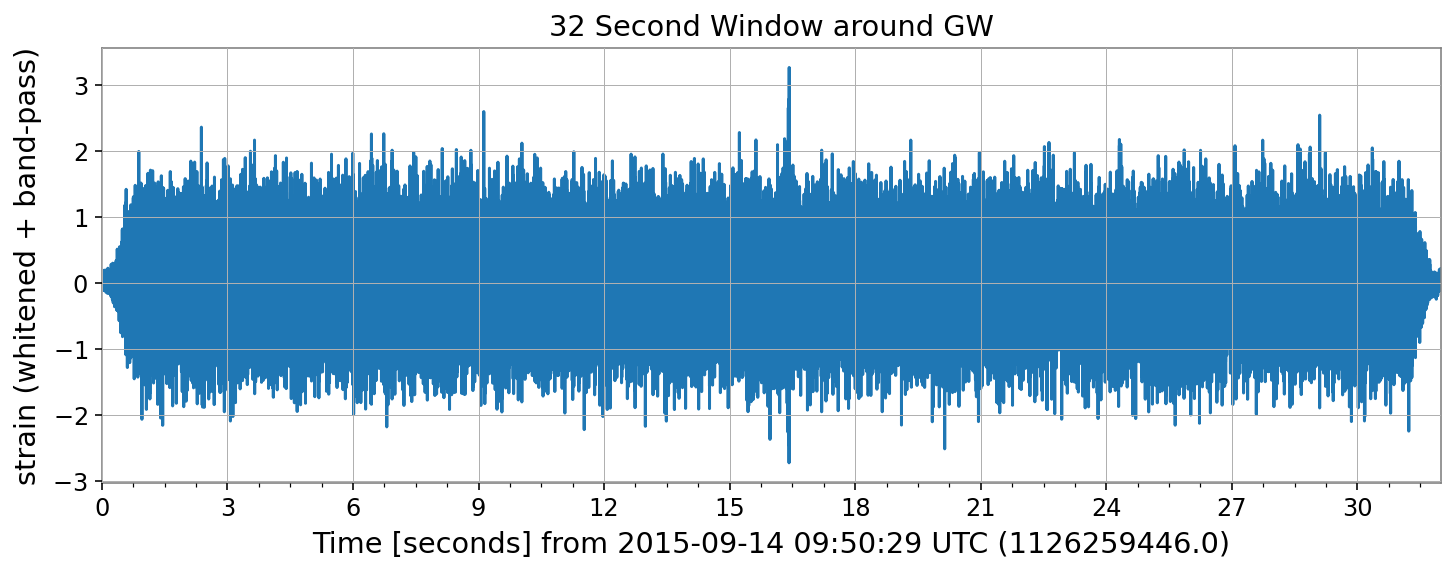

<Figure size 648x432 with 0 Axes>

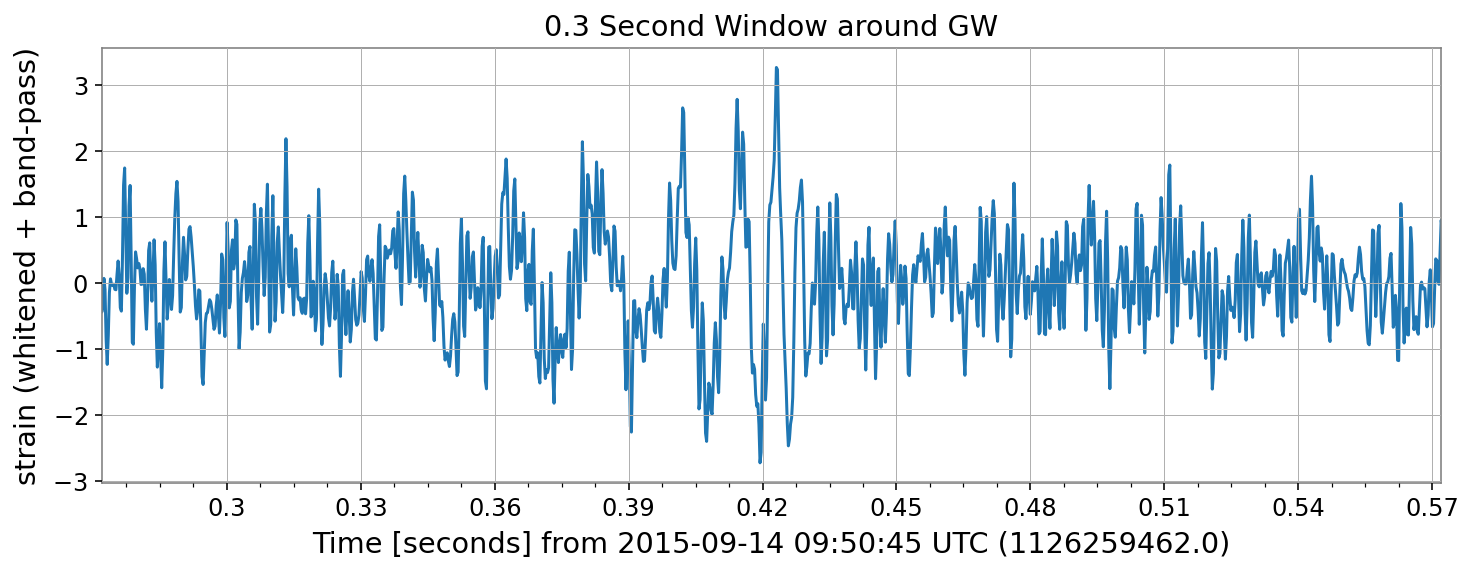

<Figure size 648x432 with 0 Axes>

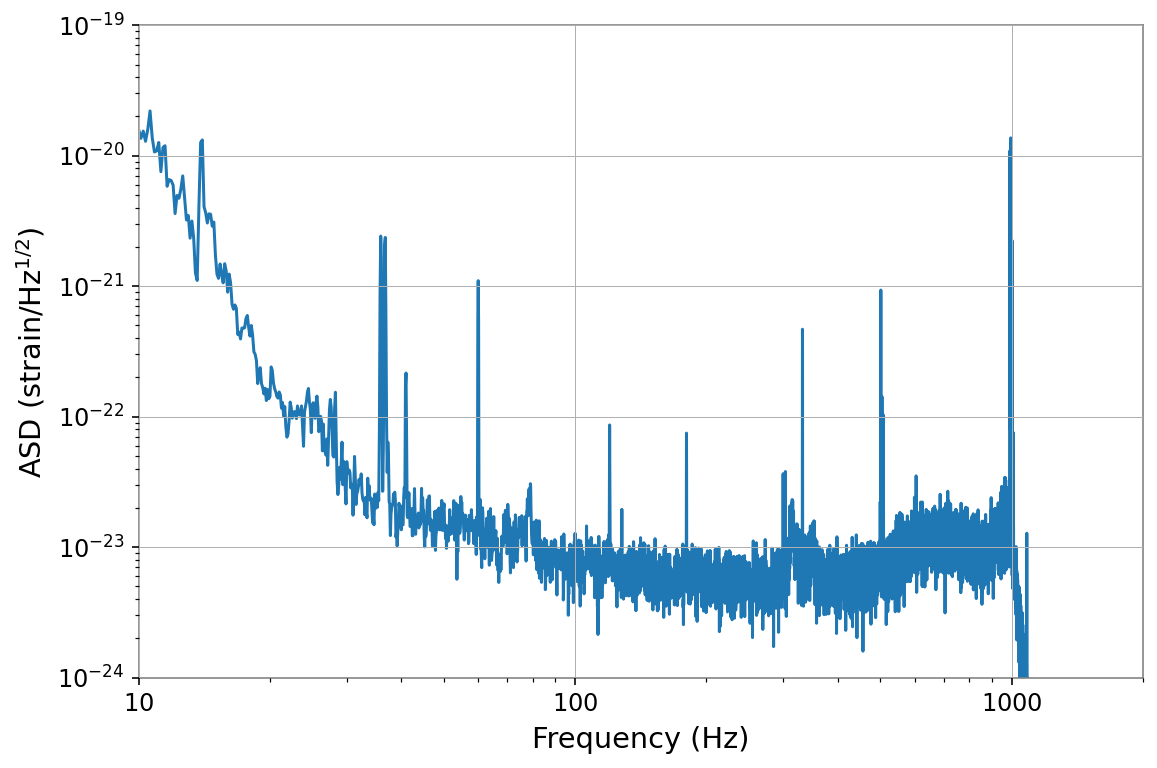

<TimeSeries([ 0.01026349, -0.04384023, -0.01024432, ...,
              0.10743095,  0.06862419,  0.08629983]
            unit=Unit(dimensionless),
            t0=<Quantity 1.12625945e+09 s>,
            dt=<Quantity 0.00024414 s>,
            name='Strain',
            channel=None)>

In [ ]:
#>>>RUN

def bandpass(bandpass_low, bandpass_high): 
  white_data_bp = white_data.bandpass(bandpass_low, bandpass_high)

  plt.clf()
  white_data_bp.plot()
  plt.ylabel('strain (whitened + band-pass)')
  plt.title('32 Second Window around GW')
  plt.show()

  plt.clf()
  white_data_bp.plot()
  plt.ylabel('strain (whitened + band-pass)')
  plt.xlim(tevent-0.15, tevent+0.15)
  plt.title('0.3 Second Window around GW')
  plt.show()

  #Note: for the sake of comparison, we are using unwhitened strain
  strain_bandpass = strain.bandpass(bandpass_low, bandpass_high) 
  asd = strain_bandpass.asd(fftlength=8)
  plt.clf()
  asd.plot()
  plt.xlim(10, 2000)
  plt.ylim(1e-24, 1e-19)
  plt.ylabel('ASD (strain/Hz$^{1/2})$')
  plt.xlabel('Frequency (Hz)')
  plt.show()
  
  return white_data_bp


bandpass_low, bandpass_high = [1,1000]
bandpass(bandpass_low, bandpass_high)

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 1.2.2</span>

Your goal in this checkpoint will be to select the correct bandpassing range based on the **Q-transform plot** we made above. In the below cell, experiment with the filter thresholds (`bandpass_low` and `bandpass_high`), and find a window leading to a **clear** signal on the upper and middle (strain) plots.  On the lower (ASD) plot, check out how this bandpass filter affects the ASD and compare to the original ASD plot!

Enter your answer as a list of two numbers, where you have chosen suitable values within the correct bandpassing range: `[bandpass_low, bandpass_high]`

Hint: Keep in mind that `bandpass_low >0` and if needed, look up the typical frequency range for a BBH merger. A *clear* signal will be around 2x larger magnitude than the normal background data.

In [15]:
#>>>PROBLEM

bandpass_low = X #YOUR CODE HERE
bandpass_high = Y #YOUR CODE HERE

white_data_bp = bandpass(bandpass_low, bandpass_high)

>#### Follow-up 1.2.2a (ungraded)
>
>Can you optimize your choice of bandpass based on some constraint on the Q-transform and/or time series data? Try to write this code and return a choice of bandpass automatically.

<a name='section_1_3'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">PROJ1.3 Analytic Model Part I - Frequency vs. Time</h2>    

| [Top](#section_1_0) | [Previous Section](#section_1_2) | [Checkpoints](#problems_1_3) | [Next Section](#section_1_4) |


<h3>Overview</h3>

In this section, you will develop an analytic model to describe a black hole merger event. Then, by fitting this model to your data, we will extract parameters of the event itself, including the reduced masses of the orbiting binary system. 

<h3>Analytic Model: Frequency vs Time</h3>

Calculating the actual waveform requires complicated numerical simulations. However, we can use the basic knowledge of General Relativity (GR) and Newtonian mechanics to perform an approximate analytic calculation for the waveform. For an orbiting binary system ($m_{1}$ and $m_{2}$), according to GR the frequency ($\omega(t)$) of the GW radiation satisfies

$$
\begin{equation}
\dot{\omega} = \frac{12}{5}2^{\frac{1}{3}}\left(\frac{G\mathcal{M}_{c}}{c^{3}}\right)^{\frac{5}{3}}\omega^{\frac{11}{3}}
\tag{1} 
\end{equation}
$$

where $G$ and $c$ are gravitational constant and the speed of light respectively. $\mathcal{M}_{c}$ is so-called chirp mass, defined by

$$
\begin{equation}
\mathcal{M}_{c} = \frac{(m_{1}m_{2})^{\frac{3}{5}}}{(m_{1}+{m_{2}})^{\frac{1}{5}}}
\tag{2}
\end{equation}
$$

Integrating Eq. [1], we can get

$$
\begin{eqnarray}
\int\omega^{-\frac{11}{3}}d\omega &= \int\frac{12}{5}2^{\frac{1}{3}}\left(\frac{G\mathcal{M}_{c}}{c^{3}}\right)^{\frac{5}{3}}dt \tag{3}\\
    \Rightarrow \omega(t) &= \frac{5^{\frac{3}{8}}}{4}\left(\frac{c^{3}}{G\mathcal{M}_{c}}\right)^{\frac{5}{8}}\Delta t^{-\frac{3}{8}} \tag{4}\\
\end{eqnarray}
$$

Now we get the time dependence of frequency. Considering

$$
\begin{equation}
  \frac{GM_{\odot}}{c^{3}} \approx 4.93~\mathrm{\mu s}
  \tag{5}
\end{equation}
$$

We have

$$
\begin{equation}
  \omega(t) = 948.5\left(\frac{M_{\odot}}{\mathcal{M}_{c}}\right)^{\frac{5}{8}}\left(\frac{1\:\mathrm{s}}{\Delta t}\right)^{\frac{3}{8}}\;\mathrm{[Hz\cdot rad]}
  \tag{6}
\end{equation}
$$

This is a first order frequency equation. For a second-order derivation of this equation, check out this paper: Gravitational-Radiation Damping of Compact Binary System to Second Post-Newtonian order by Luc Blanchet et al. [[PRL]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.74.3515), [[ArXiv]]( https://arxiv.org/pdf/gr-qc/9501027.pdf).

<h3>Plotting the Model</h3>

Now let's plot this function and see how it looks like. Compare it to the Q-Transform (lower plot) and notice that they are very similar in shape. 

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 1.3.1</span>

Now let's plot this function and see what it looks like compared to the Q-transform. First, fill in the code below to define the function.

In [16]:
#>>>PROBLEM

def gwfreq(iT, iM,iT0, cutoff=2e-3):
    #Returns the frequency of a gravitational wave at a specific time in merger
    #iM : chirp mass in units of solar masses 
    #iT : time where frequency is being sampled
    #iT0 : time where complete merger occurs
    #cutoff : arbritrary time window where merger ends before iT0
    
    const = #YOUR CODE HERE
    idelta_T = #YOUR CODE HERE, should be array of differences (iT0 - iT)
    output = const*np.power(np.maximum(idelta_T, cutoff),-3./8.)
    return output



<h3>Comparison</h3>

Run the code below to compare the model function to the Q-Transform (lower plot). Notice that they are very similar in shape. 

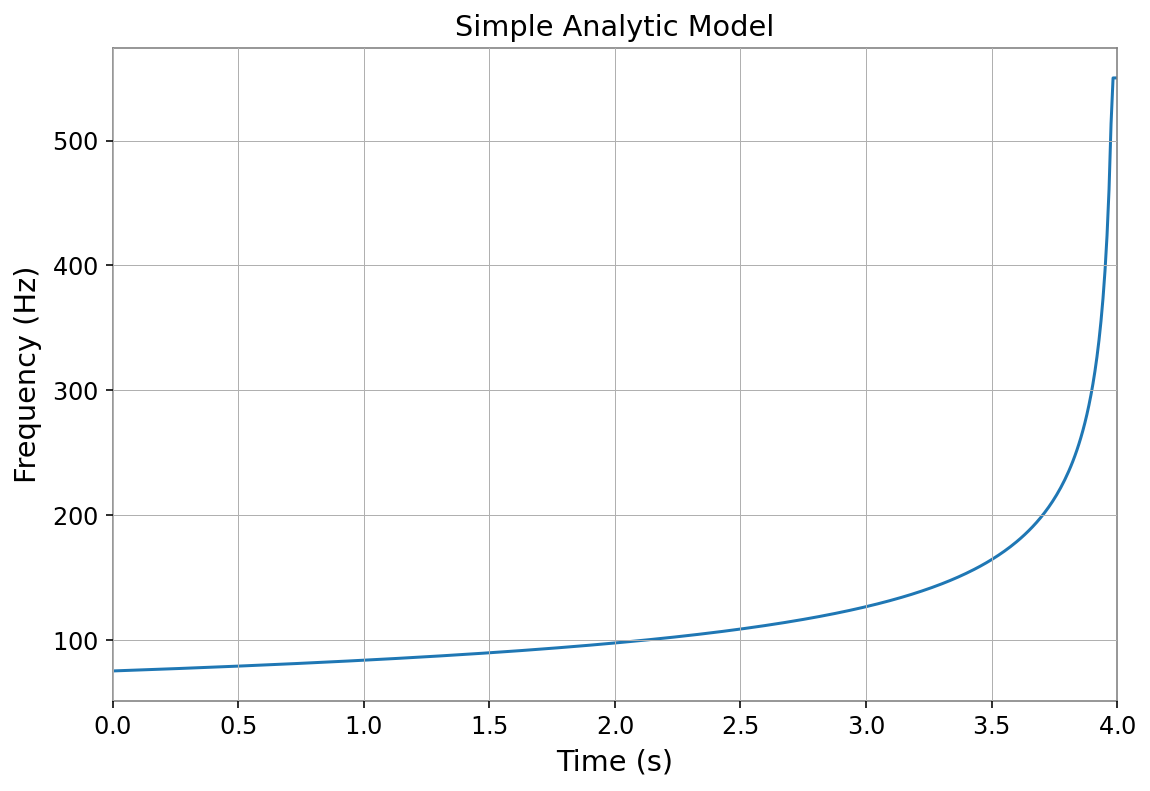

<Figure size 648x432 with 0 Axes>

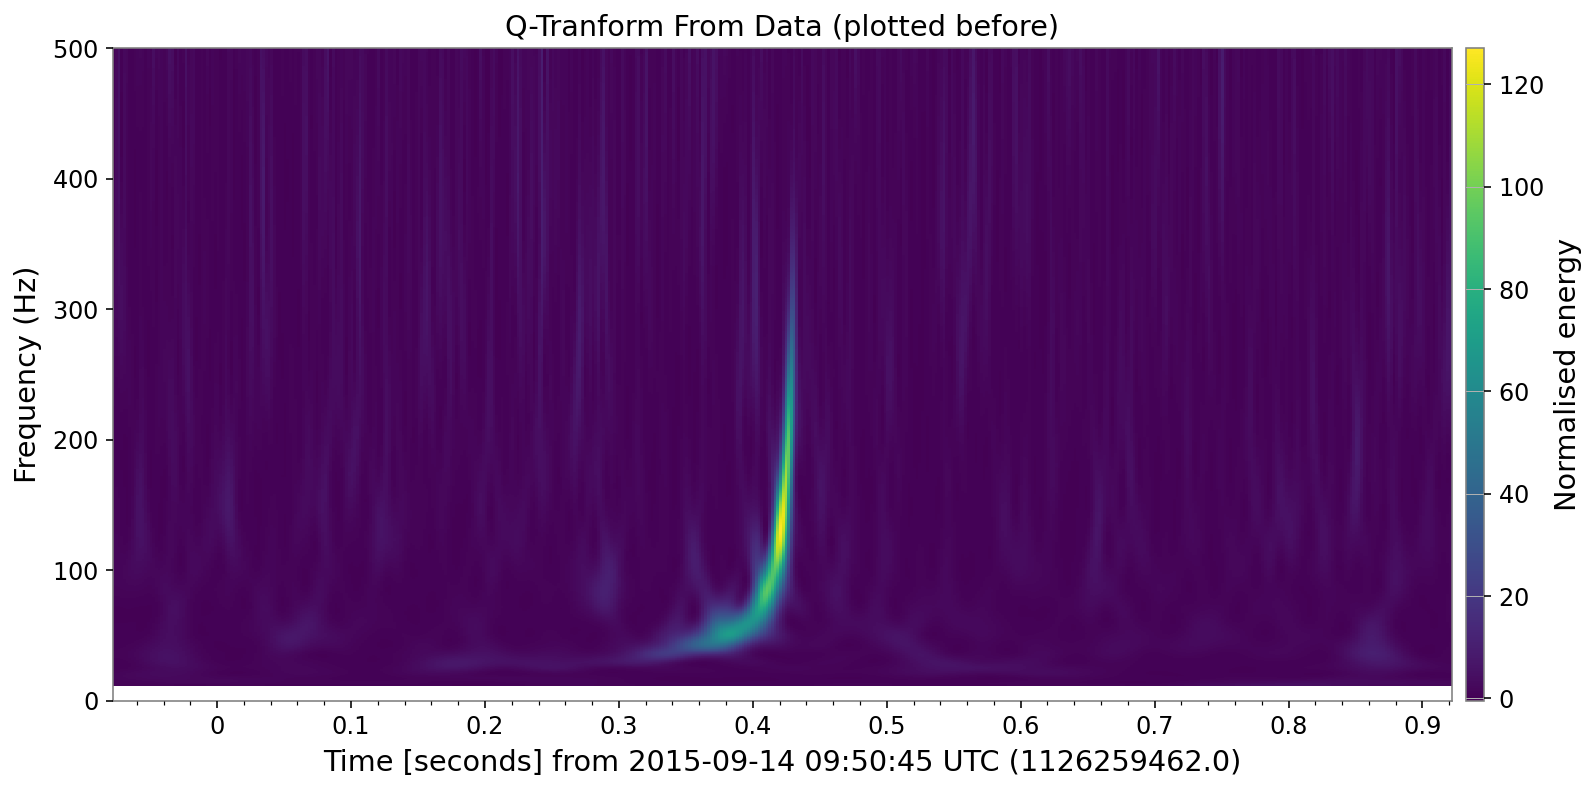

In [ ]:
#>>>RUN

# sampling time from t= 0s to t= 4s
times = np.linspace(0, 4., 500)

# frequency of a 20 solar chirp mass system merging at t=0
freq = gwfreq(iT=times, iM=25, iT0=4, cutoff=2e-2)

plt.clf()
plt.plot(times, freq)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Simple Analytic Model')
plt.xlim(0, 4)
plt.show()


# Plotting Q-Transform shape for comparison
dt = 1  #-- Set width of q-transform plot, in seconds
hq = strain.q_transform(outseg=(tevent-dt, tevent+dt))

plt.clf()
fig = hq.plot()
ax = fig.gca()
fig.colorbar(label="Normalised energy")
ax.grid(False)
plt.xlim(tevent-0.5, tevent+0.5)
plt.ylim(0, 500)
plt.ylabel('Frequency (Hz)')
plt.title('Q-Tranform From Data (plotted before)')
plt.show()

<h3>Fitting Frequency vs. Time</h3>

Can we fit the GW model to the Q-transform? Would this yeild meaningful fit parameters?

First, we must project the amplitude of the Q-transform into the frequency-time domain. You can try to do this your own way, but we have included code below for one such method.

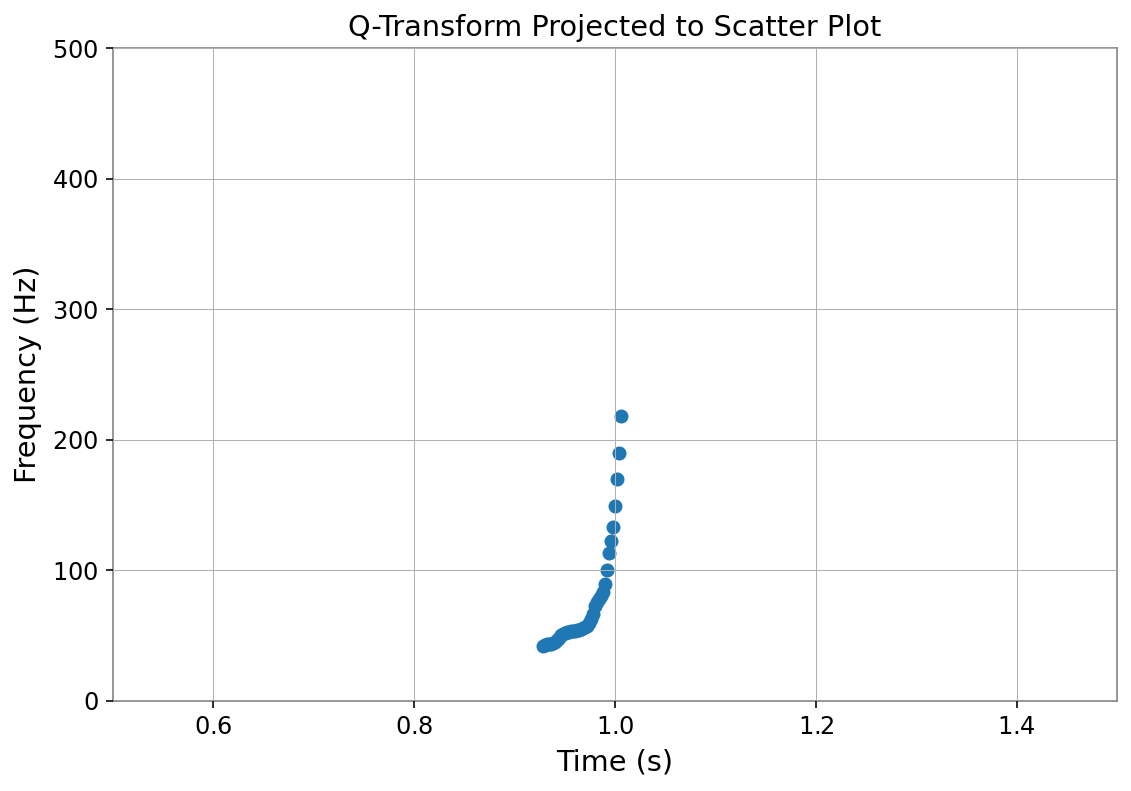

In [ ]:
#>>>RUN

def project_spectrogram(hq, threshold=30): 
  '''
  Given a spectrogram and threshold, this function will project down the 3D 
  spectrogram into a scatter plot by picking the points in intensity that lie
  above the threshold

  hq : spectrogram
  threshold : energy intensity above which points are chosen for projection
  '''
  projected_spec_times = []
  projected_spec_freq = []

  offset = hq.t0
  hq.times -= hq.t0
  hq_times = hq.times.value
  hq_freq = hq.frequencies.value
  hq_values = hq.value

  # Pick spectrogram values above threshold
  for x_pixel in range(hq.shape[0]): 
      for y_pixel in range(hq.shape[1]):
          if hq_values[x_pixel, y_pixel] > threshold: 
            projected_spec_times.append(hq_times[x_pixel])
            projected_spec_freq.append(hq_freq[y_pixel])

  # Average over y-values corresponding to same x-values
  fixed_projection_times = []
  fixed_projection_freq = []
  pool = []
  for i in range(len(projected_spec_times)-1): 
    if projected_spec_times[i] == projected_spec_times[i+1]:
      pool.append(projected_spec_freq[i])
    else: 
      fixed_projection_times.append(projected_spec_times[i])
      fixed_projection_freq.append(np.mean(pool))
      pool = []
  return fixed_projection_times, fixed_projection_freq

projected_spec_times, projected_spec_freq = project_spectrogram(hq)

plt.figure()
plt.scatter(projected_spec_times, projected_spec_freq)
plt.xlim((0.5, 1.5))
plt.ylim((0, 500))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Q-Transform Projected to Scatter Plot')
plt.show()

Next, we define a function to minimize, which is the difference between our fit and the projected Q-transform data. We perform the fitting below. **Your goal in this checkpoint will be to analyze the results of this fit.**

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 40
    # variables        = 3
    chi-square         = 29.6386593
    reduced chi-square = 0.80104484
    Akaike info crit   = -5.99199555
    Bayesian info crit = -0.92535719
[[Variables]]
    iM:      656.913444 +/- 33.2246381 (5.06%) (init = 25)
    iT0:     1.00136462 +/- 6.4438e-04 (0.06%) (init = 1)
    cutoff:  0.00165055 +/- 1.7635e-04 (10.68%) (init = 0.02)
[[Correlations]] (unreported correlations are < 0.100)
    C(iM, cutoff)  = -0.789
    C(iM, iT0)     = -0.713
    C(iT0, cutoff) = 0.563


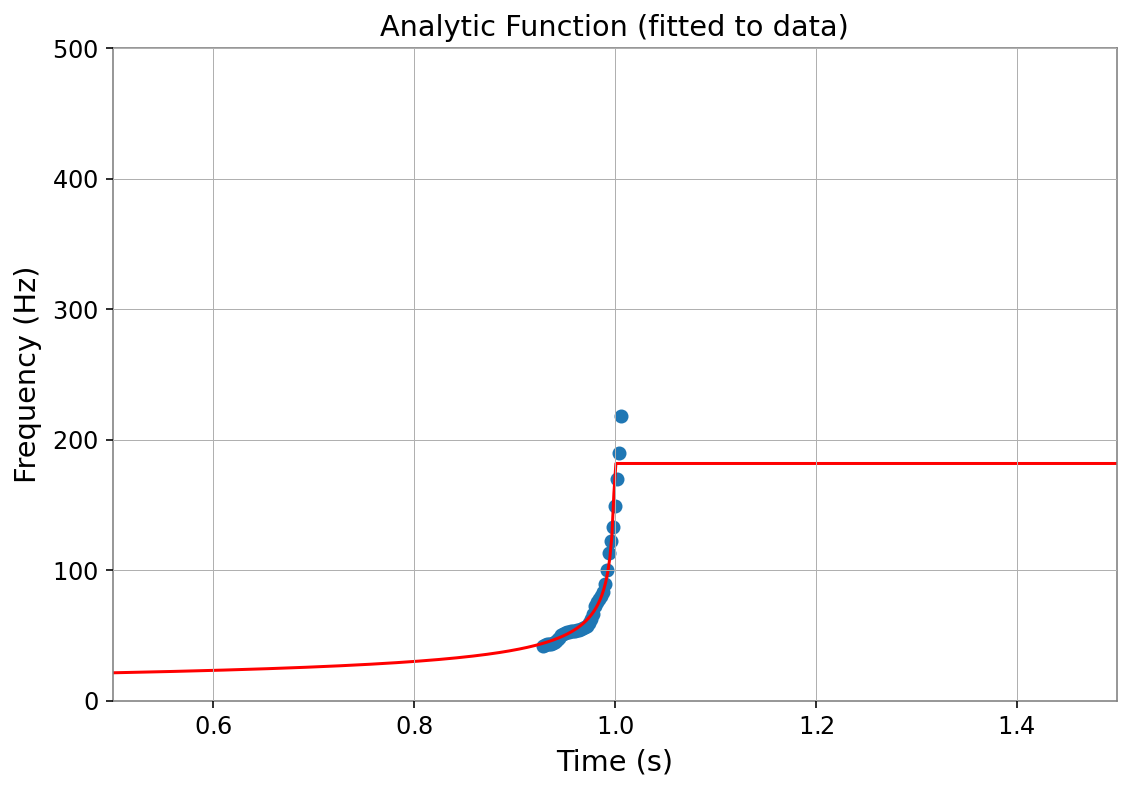

In [ ]:
#>>>RUN

# define osc_dif for lmfit::minimize()
def gwfreq_dif(params, x, data, eps):
  iM=params["iM"]
  iT0=params["iT0"]
  cutoff=params["cutoff"]
  val=gwfreq(x, iM, iT0, cutoff)
  return (val-data)/eps

model = lmfit.Model(gwfreq)
p = model.make_params()
p['iM'].set(25)     # Mass guess
p['iT0'].set(1)  # By construction we put the merger in the center
p['cutoff'].set(2e-2)
unc = np.full(len(projected_spec_freq),10)
out = minimize(gwfreq_dif, params=p, args = (projected_spec_times, projected_spec_freq, unc))
print(fit_report(out))


plt.figure()
plt.scatter(projected_spec_times, projected_spec_freq)
plt.xlim((0.5, 1.5))
plt.ylim((0, 500))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.plot(np.linspace(0.5, 1.5, 500), model.eval(params=out.params,iT=np.linspace(0.5, 1.5, 500)),'r',label='best fit')
plt.title('Analytic Function (fitted to data)')
plt.show()


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 1.3.2</span>

What is the chirp mass of the merger according to the best fit? Round to the nearest integer mass.

Hint: Look at the fit summary for information about the fit. 

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 1.3.3</span>

Why isn't this fit producing a reasonable number for the chirp mass value? Choose **two** of the following options:

- The fitted function is completely incorrect form given the real data.
- The frequency-domain fit will always have a $t^{-3/8}$ power law and so the fit isn't sensitive to chirp mass.
- Uncertainty values were too large on the real data.
- Q-transform projection to 2-dimensions doesn't capture the edges or tails of the GW in frequency space. 

>#### Follow-up 1.3.3a (ungraded)
>
>Is there a better way to project down the Q-transform? Try it! Does this improve the mass value or chi-squared from the fit at all? 

<a name='section_1_4'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">PROJ1.4 Analytic Model Part II - Strain vs. Time</h2>    

| [Top](#section_1_0) | [Previous Section](#section_1_3) | [Checkpoints](#problems_1_4) | [Next Section](#section_1_5) |


<h3>Analytic Model: Waveform before merger</h3>

Now, we build the waveform with the radiation power $dE(t)/dt$.

$$
\begin{eqnarray}
\\
f(t) &= A(t)\cos(\omega(t)\Delta t +\phi) \tag{7}\\
&\propto \frac{dE(t)}{dt}\cos(\omega(t)\Delta t +\phi) \tag{8} \\
\\
\end{eqnarray}
$$


With Newtonian mechanics, we know the energy of a binary orbit is

$$
\begin{eqnarray}
\\
    E &= E_{\mathrm{k}} + E_{\mathrm{u}} \tag{9}\\
    &= \frac{1}{2}\mu\dot{r}^{2} + \frac{1}{2}\frac{m_{1}m_{2}}{m_{1}+m_{2}}\omega^{2}R^{2} - \frac{Gm_{1}m_{2}}{R} \tag{10}\\
   &= \frac{1}{2}\frac{m_{1}m_{2}}{m_{1}+m_{2}}\omega^{2}R^{2} - \frac{Gm_{1}m_{2}}{R} \tag{11}\\ 
   \\
\end{eqnarray}
$$

The last step is because $\dot{r} = 0$. According to Kepler's third law,

$$
\begin{equation}
\\
\tag{12}
  \omega^{2} = \frac{G(m_{1}+m_{2})}{R^{3}}
\\
\end{equation}
$$

Put Eq. [12] into Eq. [11] and substitute $R$, we have

$$
\begin{eqnarray}
E &= -\frac{Gm_{1}m_{2}}{2R} \tag{13}\\
\tag{14}    &\propto \mathcal{M}_{c}^{\frac{5}{3}}\omega(t)^{\frac{2}{3}} \\
\\
\end{eqnarray}
$$

Perform derivatives on Eq. [14],

$$
\begin{eqnarray}
\frac{dE}{dt} &\propto \mathcal{M}_{c}^{\frac{5}{3}}\omega(t)^{-\frac{1}{3}}\dot{\omega} \tag{15}\\
\tag{16}    &\propto \left(\mathcal{M}_{c}\omega(t)\right)^{\frac{10}{3}} \\
\\
\end{eqnarray}
$$

Put Eq. [16] into Eq. [8], we have the waveform

$$
\begin{eqnarray}
\tag{17}
f(t) &= C\left(\mathcal{M}_{c}\omega(t)\right)^{\frac{10}{3}}\cos(\omega(t)\Delta t +\phi), \\
\\
\end{eqnarray}
$$

and $C$ is a constant. We can use the result that we derived before, for $\omega(t)$:

$$
\begin{eqnarray}
\omega(t) &= 948.5\left(\frac{M_{\odot}}{\mathcal{M}_{c}}\right)^{\frac{5}{8}}\left(\frac{1\:\mathrm{s}}{\Delta t}\right)^{\frac{3}{8}}\;\mathrm{[Hz\cdot rad]} \tag{18} \\
\\
\end{eqnarray}
$$

<h3>Analytic Model: Waveform after merger</h3>

The waveform amplitude above is only supposed to work before merger ($t \leq t_{0}$), and we need to come up with a way to define the ringdown amplitude ($t > t_{0}$). The actual way to get the amplitude requires months of a super computer to build good templates! As a simple approximate solution, you can use a simple exponential decay function. It will be your next task to write this function.

First, run the code below to properly bandpass filter the data (if you have not done this already). This will define the data to which we will fit our function. Use the bandpass values below, as your fit results will be compared to results that we computed using these parameters.

<Figure size 648x432 with 0 Axes>

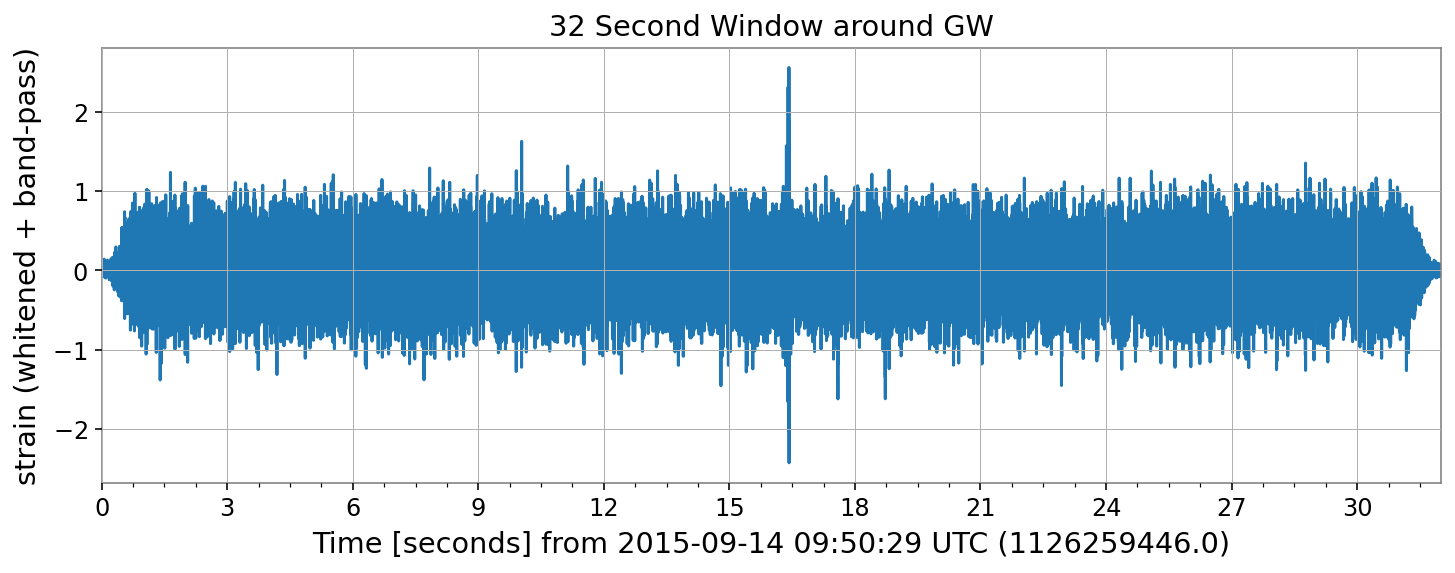

<Figure size 648x432 with 0 Axes>

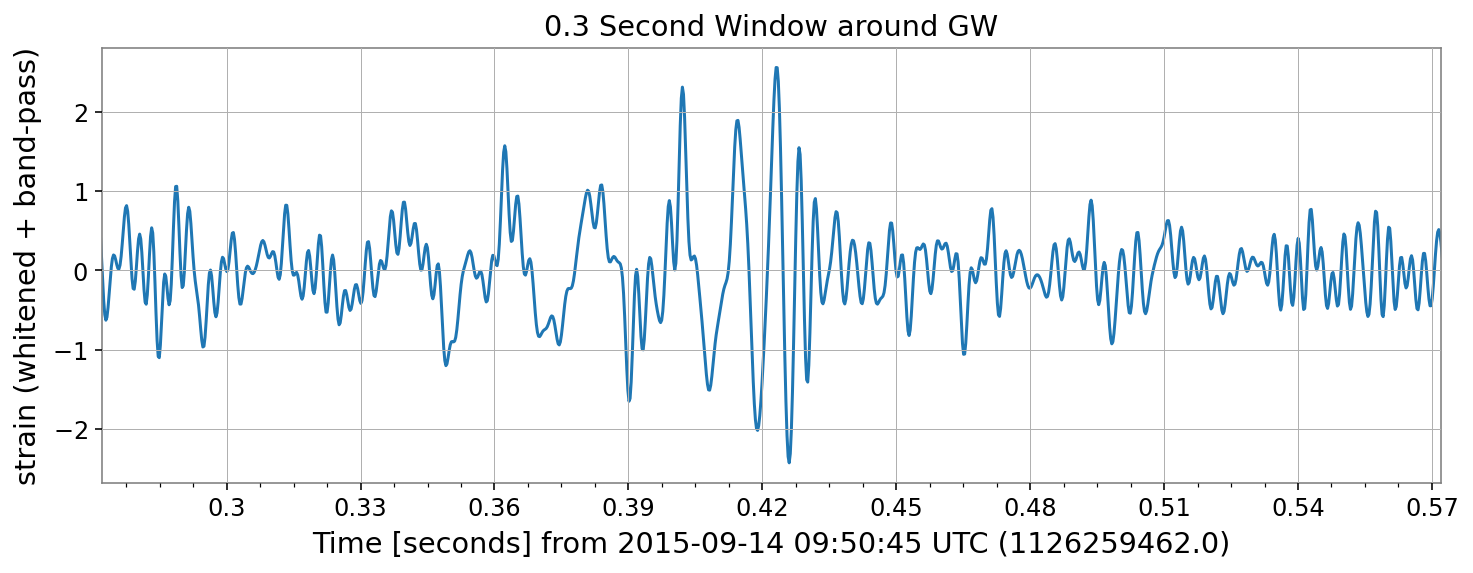

<Figure size 648x432 with 0 Axes>

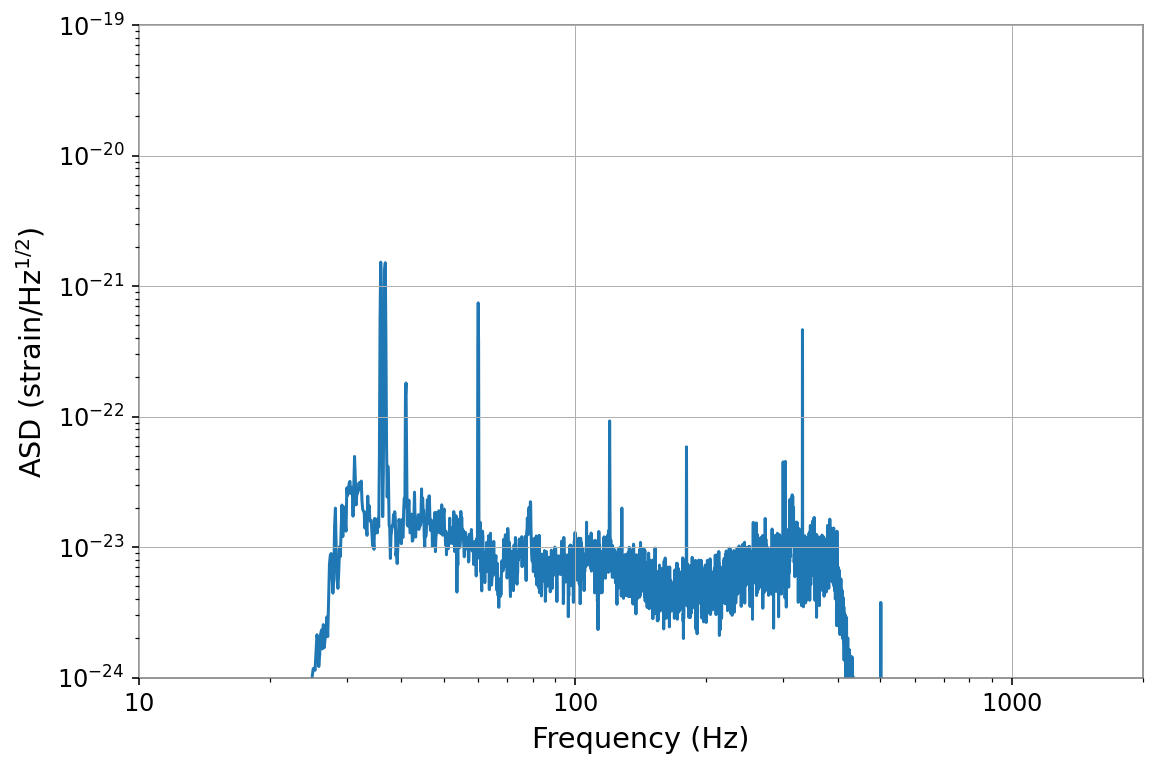

In [ ]:
#>>>RUN

#BE SURE TO SET THE VALUES OF YOUR BANDPASS TO THE FOLLOWING:
bandpass_low = 30 #YOUR CODE HERE
bandpass_high = 400 #YOUR CODE HERE
white_data_bp = bandpass(bandpass_low, bandpass_high)

Now, in the code below, we have set up all of the fitting apparatus, which does the following:
- `osc_dif`: defines a function to minimize
- `plot_fit_function_not_fitted`: plots the fit function without performing lmfit, for some default input values
- `plot_fit_function_fitted`: plots the fit function after performing lmfit and prints the fit report
- `osc`: the function to be fit, which takes the variables `(t, Mc, t0, C, phi, tau)`.

For `osc`, we have written a simple sinusiodal function, which obviously is not an appropriate fit for the data. The varibale `tau` is left as an extra free-parameter that you may choose to use.

Run the code below to see the output, then consider the following questions.

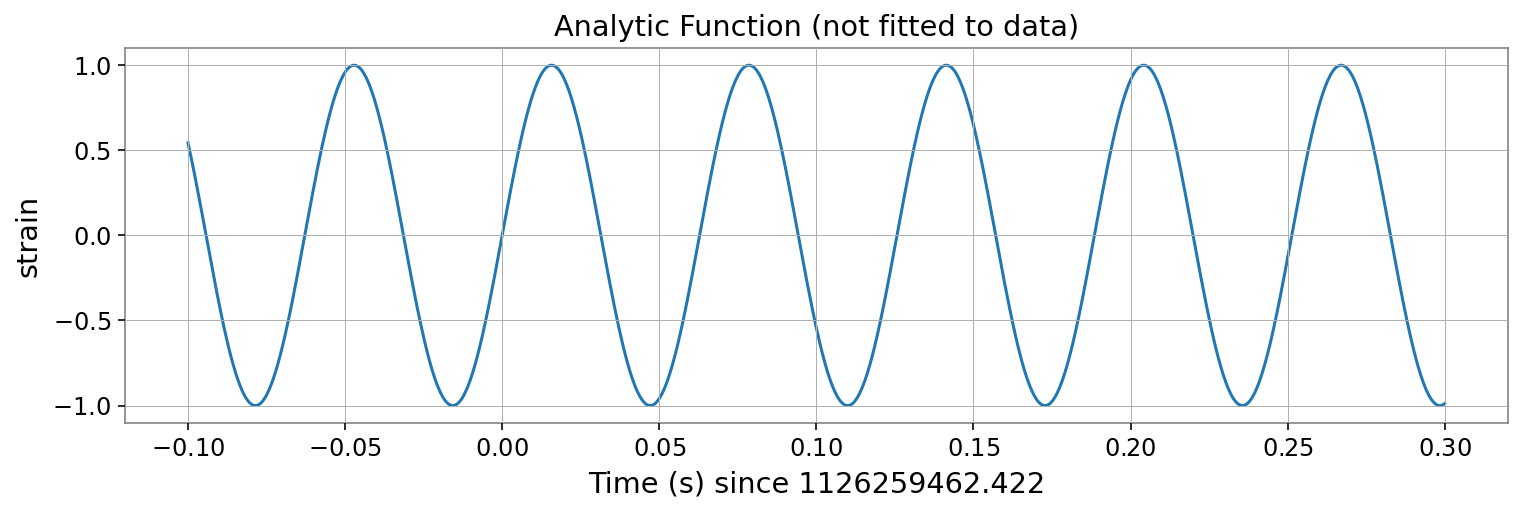

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 1228
    # variables        = 6
    chi-square         = 3054.34407
    reduced chi-square = 2.49946323
    Akaike info crit   = 1130.92662
    Bayesian info crit = 1161.60548
##  Warning: uncertainties could not be estimated:
    Mc:      at initial value
    t0:      at initial value
    cutoff:  at initial value
    C:       at initial value
[[Variables]]
    Mc:      25.0000000 (init = 25)
    t0:      0.17000000 (init = 0.17)
    cutoff:  0.00200000 (init = 0.002)
    C:       1.0000e-12 (init = 1e-12)
    phi:     0.00000000 (init = 0)
    tau:     0.00000000 (init = 0)


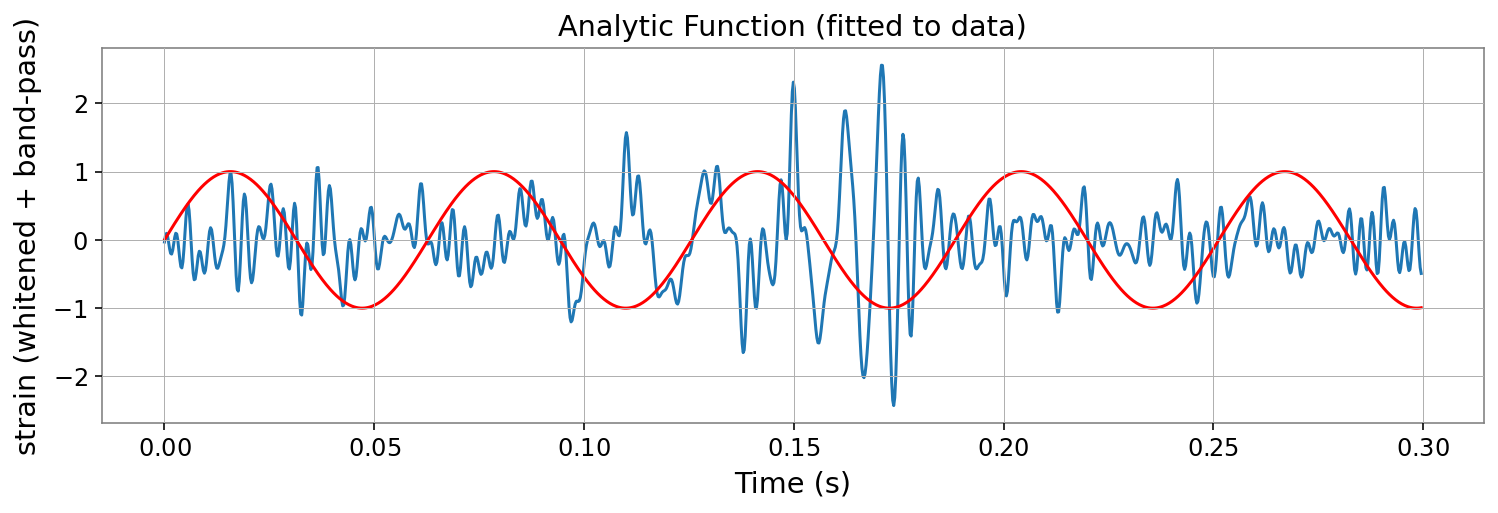

In [ ]:
#>>>RUN

# define osc_dif for lmfit::minimize()
def osc_dif(params, x, data, eps):
  iM=params["Mc"]
  iT0=params["t0"]
  cutoff=params['cutoff']
  norm=params["C"]
  phi=params["phi"]
  tau=params["tau"]
  
  val=osc(x, iM, iT0, cutoff, norm, phi, tau)
  return (val-data)/eps

def plot_fit_function_not_fitted(function):
  times = np.linspace(-0.1, 0.3, 1000)
  freq = function(times, 30, 0.18, 1e-2, 1, 0, 0)
  plt.figure(figsize=(12, 4))
  plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
  plt.plot(times, freq)
  plt.xlabel('Time (s) since '+str(tevent))
  plt.ylabel('strain')
  plt.title('Analytic Function (not fitted to data)')
  plt.show()


def plot_fit_function_fitted(function):
  sample_times = white_data_bp.times.value
  sample_data = white_data_bp.value
  indxt = np.where((sample_times >= (tevent-0.17)) & (sample_times < (tevent+0.13)))
  x = sample_times[indxt]
  x = x-x[0]
  white_data_bp_zoom = sample_data[indxt]

  plt.figure(figsize=(12, 4))
  plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
  plt.plot(x, white_data_bp_zoom)
  plt.xlabel('Time (s)')
  plt.ylabel('strain (whitened + band-pass)')

  model = lmfit.Model(osc)
  p = model.make_params()
  p['Mc'].set(25)     # Mass guess
  p['t0'].set(0.17)  # By construction we put the merger in the center
  p['cutoff'].set(2e-3)
  p['C'].set(1e-12)      # normalization guess 
  p['phi'].set(0)    # Phase guess
  p['tau'].set(0)    # Phase guess
  unc = np.full(len(white_data_bp_zoom),np.std(white_data_bp_zoom))
  out = minimize(osc_dif, params=p, args=(x, white_data_bp_zoom, unc))
  print(fit_report(out))
  plt.plot(x, model.eval(params=out.params,t=x),'r',label='best fit')
  plt.title('Analytic Function (fitted to data)')
  plt.show()

def osc(t, Mc, t0, cutoff, C, phi, tau):
    # Example code to show how plot_fit_function_fitted
    val = np.sin(100*t)
    return val

plot_fit_function_not_fitted(osc)
plot_fit_function_fitted(osc)

<a name='problems_1_3'></a>     

| [Top](#section_1_0) | [Restart Section](#section_1_4) | [Next Section](#section_1_5) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 1.4.1</span>

Build a function `osc(t, Mc, t0, cutoff, C, phi, tau)`, which will properly model the oscillation of the waveform. It has the form as Eq. [17] for $t \leq t_{0}$, but dampens to zero for $t > t_{0}$. Run the fit in your notebook and comment on your chi-squared **in the frequency domain** (as you performed in pset 2).

Hint: Remember to use a exponential decay function. Recall that the frequency of the GW can be found using `gwfreq(iT,iM,iT0)` as defined above.

To score the result of your fit, we will independently fit your function `osc(t, Mc, t0, cutoff, C, phi, tau)` against a different set of data. Your function will be accepted if it produces a reduced chi-sq `<=0.6`.

In [ ]:
#>>>PROBLEM
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

print('def osc(t, Mc, t0, cutoff, C, phi, tau):')

def osc(t, Mc, t0, cutoff, C, phi, tau):
    # Enter code here
    val = 0
    return val

def osc(t, Mc, t0, cutoff, C, phi, tau):


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 355
    # data points      = 1228
    # variables        = 5
    chi-square         = 697.648179
    reduced chi-square = 0.57044005
    Akaike info crit   = -684.344570
    Bayesian info crit = -658.778859
[[Variables]]
    Mc:      18.2990687 +/- 0.32320542 (1.77%) (init = 25)
    t0:      0.17309565 +/- 4.0253e-04 (0.23%) (init = 0.17)
    cutoff:  0.01037463 +/- 3.8449e-04 (3.71%) (init = 0.002)
    C:       2.1345e-14 +/- 1.2487e-15 (5.85%) (init = 1e-12)
    phi:    -2.35249971 +/- 0.33636673 (14.30%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, phi)     = -0.992
    C(Mc, phi)     = 0.937
    C(Mc, t0)      = -0.915
    C(cutoff, C)   = 0.802
    C(t0, cutoff)  = 0.788
    C(Mc, cutoff)  = -0.772
    C(cutoff, phi) = -0.766
    C(Mc, C)       = -0.746
    C(t0, C)       = 0.712
    C(C, phi)      = -0.708


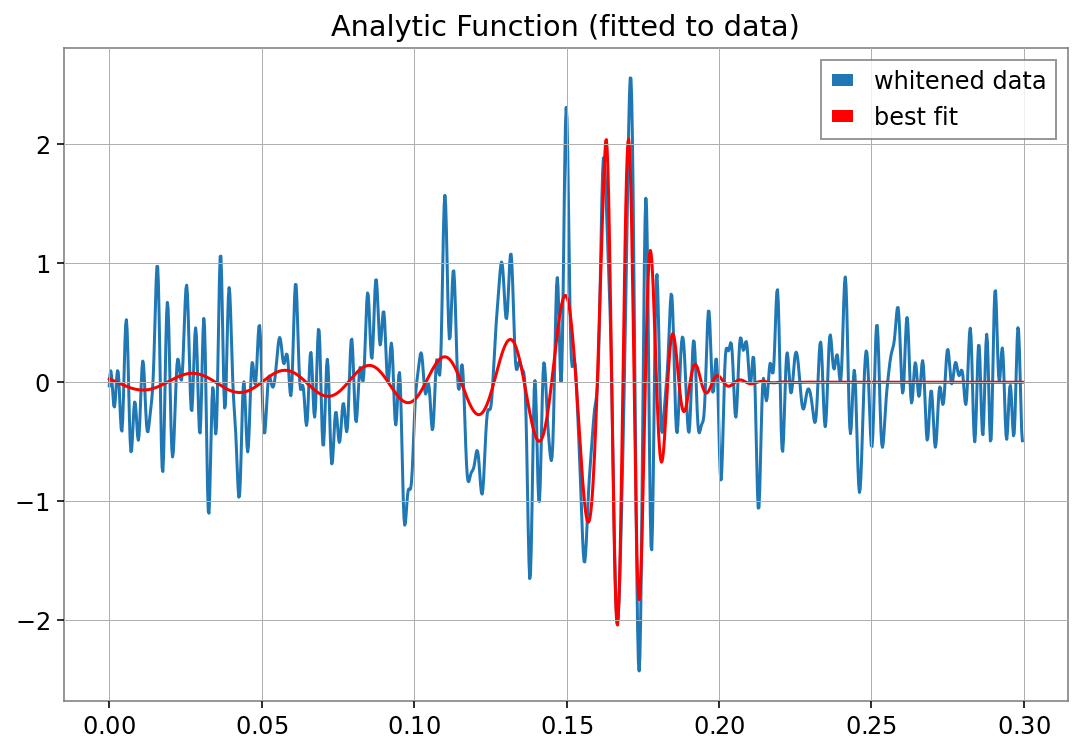

reduced chisq: 0.5704400484587245
reduced chisq < 0.8: True


In [ ]:
# Code to check results fit:

import numpy as np
import wget
from gwpy.timeseries import TimeSeries
import lmfit
from lmfit import Model, minimize, fit_report, Parameters
import matplotlib.pyplot as plt

def gwfreq(iT, iM,iT0, cutoff):
    '''
    Returns the frequency of a gravitational wave at a specific time in merger

    iM : chirp mass in units of solar masses 
    iT : time where frequency is being sampled
    iT0 : time where complete merger occurs
    cutoff : arbritrary unit scaling for cutoff frequency where merger ends
    '''
    #cutoff = 2e-3
    const = (948.5)*np.power(np.divide(1.,iM),5./8.)
    output = const*np.power(np.maximum(np.subtract(iT0, iT), cutoff),-3./8.)
    return output


def osc_dif(params, x, data, eps):
  iM=params["Mc"]
  iT0=params["t0"]
  cutoff=params['cutoff']
  norm=params["C"]
  phi=params["phi"]
  val=osc(x, iM, iT0, cutoff, norm, phi)
  return (val-data)/eps

def fit_function(function, x, white_data): 
  times = np.linspace(-0.1, 0.3, 1000)
  freq = function(times, 30, 0.18, 1e-2, 1, 0)
  white_data_bp_zoom = white_data
  model = lmfit.Model(osc)
  p = model.make_params()
  p['Mc'].set(25)     # Mass guess
  p['t0'].set(0.17)  # By construction we put the merger in the center
  p['cutoff'].set(2e-3)
  p['C'].set(1e-12)      # normalization guess 
  p['phi'].set(0)    # Phase guess
  unc = np.full(len(white_data_bp_zoom),np.std(white_data_bp_zoom))

  out = minimize(osc_dif, params=p, args=(x, white_data_bp_zoom, unc))
    
  print(fit_report(out))
  plt.plot(x,white_data_bp_zoom,label='whitened data')
  plt.plot(x, model.eval(params=out.params,t=x),'r',label='best fit')
  plt.title('Analytic Function (fitted to data)')
  plt.legend()
  plt.show()
  return out
  

#L1 = wget.download('https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5')
#fn = 'L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5' # data file
#tevent = 1126259462.422 

x = np.array([0.00000000e+00, 2.44140625e-04, 4.88281250e-04,
       7.32421875e-04, 9.76562500e-04, 1.22070312e-03,
       1.46484375e-03, 1.70898438e-03, 1.95312500e-03,
       2.19726562e-03, 2.44140625e-03, 2.68554688e-03,
       2.92968750e-03, 3.17382812e-03, 3.41796875e-03,
       3.66210938e-03, 3.90625000e-03, 4.15039062e-03,
       4.39453125e-03, 4.63867188e-03, 4.88281250e-03,
       5.12695312e-03, 5.37109375e-03, 5.61523438e-03,
       5.85937500e-03, 6.10351562e-03, 6.34765625e-03,
       6.59179688e-03, 6.83593750e-03, 7.08007812e-03,
       7.32421875e-03, 7.56835938e-03, 7.81250000e-03,
       8.05664062e-03, 8.30078125e-03, 8.54492188e-03,
       8.78906250e-03, 9.03320312e-03, 9.27734375e-03,
       9.52148438e-03, 9.76562500e-03, 1.00097656e-02,
       1.02539062e-02, 1.04980469e-02, 1.07421875e-02,
       1.09863281e-02, 1.12304688e-02, 1.14746094e-02,
       1.17187500e-02, 1.19628906e-02, 1.22070312e-02,
       1.24511719e-02, 1.26953125e-02, 1.29394531e-02,
       1.31835938e-02, 1.34277344e-02, 1.36718750e-02,
       1.39160156e-02, 1.41601562e-02, 1.44042969e-02,
       1.46484375e-02, 1.48925781e-02, 1.51367188e-02,
       1.53808594e-02, 1.56250000e-02, 1.58691406e-02,
       1.61132812e-02, 1.63574219e-02, 1.66015625e-02,
       1.68457031e-02, 1.70898438e-02, 1.73339844e-02,
       1.75781250e-02, 1.78222656e-02, 1.80664062e-02,
       1.83105469e-02, 1.85546875e-02, 1.87988281e-02,
       1.90429688e-02, 1.92871094e-02, 1.95312500e-02,
       1.97753906e-02, 2.00195312e-02, 2.02636719e-02,
       2.05078125e-02, 2.07519531e-02, 2.09960938e-02,
       2.12402344e-02, 2.14843750e-02, 2.17285156e-02,
       2.19726562e-02, 2.22167969e-02, 2.24609375e-02,
       2.27050781e-02, 2.29492188e-02, 2.31933594e-02,
       2.34375000e-02, 2.36816406e-02, 2.39257812e-02,
       2.41699219e-02, 2.44140625e-02, 2.46582031e-02,
       2.49023438e-02, 2.51464844e-02, 2.53906250e-02,
       2.56347656e-02, 2.58789062e-02, 2.61230469e-02,
       2.63671875e-02, 2.66113281e-02, 2.68554688e-02,
       2.70996094e-02, 2.73437500e-02, 2.75878906e-02,
       2.78320312e-02, 2.80761719e-02, 2.83203125e-02,
       2.85644531e-02, 2.88085938e-02, 2.90527344e-02,
       2.92968750e-02, 2.95410156e-02, 2.97851562e-02,
       3.00292969e-02, 3.02734375e-02, 3.05175781e-02,
       3.07617188e-02, 3.10058594e-02, 3.12500000e-02,
       3.14941406e-02, 3.17382812e-02, 3.19824219e-02,
       3.22265625e-02, 3.24707031e-02, 3.27148438e-02,
       3.29589844e-02, 3.32031250e-02, 3.34472656e-02,
       3.36914062e-02, 3.39355469e-02, 3.41796875e-02,
       3.44238281e-02, 3.46679688e-02, 3.49121094e-02,
       3.51562500e-02, 3.54003906e-02, 3.56445312e-02,
       3.58886719e-02, 3.61328125e-02, 3.63769531e-02,
       3.66210938e-02, 3.68652344e-02, 3.71093750e-02,
       3.73535156e-02, 3.75976562e-02, 3.78417969e-02,
       3.80859375e-02, 3.83300781e-02, 3.85742188e-02,
       3.88183594e-02, 3.90625000e-02, 3.93066406e-02,
       3.95507812e-02, 3.97949219e-02, 4.00390625e-02,
       4.02832031e-02, 4.05273438e-02, 4.07714844e-02,
       4.10156250e-02, 4.12597656e-02, 4.15039062e-02,
       4.17480469e-02, 4.19921875e-02, 4.22363281e-02,
       4.24804688e-02, 4.27246094e-02, 4.29687500e-02,
       4.32128906e-02, 4.34570312e-02, 4.37011719e-02,
       4.39453125e-02, 4.41894531e-02, 4.44335938e-02,
       4.46777344e-02, 4.49218750e-02, 4.51660156e-02,
       4.54101562e-02, 4.56542969e-02, 4.58984375e-02,
       4.61425781e-02, 4.63867188e-02, 4.66308594e-02,
       4.68750000e-02, 4.71191406e-02, 4.73632812e-02,
       4.76074219e-02, 4.78515625e-02, 4.80957031e-02,
       4.83398438e-02, 4.85839844e-02, 4.88281250e-02,
       4.90722656e-02, 4.93164062e-02, 4.95605469e-02,
       4.98046875e-02, 5.00488281e-02, 5.02929688e-02,
       5.05371094e-02, 5.07812500e-02, 5.10253906e-02,
       5.12695312e-02, 5.15136719e-02, 5.17578125e-02,
       5.20019531e-02, 5.22460938e-02, 5.24902344e-02,
       5.27343750e-02, 5.29785156e-02, 5.32226562e-02,
       5.34667969e-02, 5.37109375e-02, 5.39550781e-02,
       5.41992188e-02, 5.44433594e-02, 5.46875000e-02,
       5.49316406e-02, 5.51757812e-02, 5.54199219e-02,
       5.56640625e-02, 5.59082031e-02, 5.61523438e-02,
       5.63964844e-02, 5.66406250e-02, 5.68847656e-02,
       5.71289062e-02, 5.73730469e-02, 5.76171875e-02,
       5.78613281e-02, 5.81054688e-02, 5.83496094e-02,
       5.85937500e-02, 5.88378906e-02, 5.90820312e-02,
       5.93261719e-02, 5.95703125e-02, 5.98144531e-02,
       6.00585938e-02, 6.03027344e-02, 6.05468750e-02,
       6.07910156e-02, 6.10351562e-02, 6.12792969e-02,
       6.15234375e-02, 6.17675781e-02, 6.20117188e-02,
       6.22558594e-02, 6.25000000e-02, 6.27441406e-02,
       6.29882812e-02, 6.32324219e-02, 6.34765625e-02,
       6.37207031e-02, 6.39648438e-02, 6.42089844e-02,
       6.44531250e-02, 6.46972656e-02, 6.49414062e-02,
       6.51855469e-02, 6.54296875e-02, 6.56738281e-02,
       6.59179688e-02, 6.61621094e-02, 6.64062500e-02,
       6.66503906e-02, 6.68945312e-02, 6.71386719e-02,
       6.73828125e-02, 6.76269531e-02, 6.78710938e-02,
       6.81152344e-02, 6.83593750e-02, 6.86035156e-02,
       6.88476562e-02, 6.90917969e-02, 6.93359375e-02,
       6.95800781e-02, 6.98242188e-02, 7.00683594e-02,
       7.03125000e-02, 7.05566406e-02, 7.08007812e-02,
       7.10449219e-02, 7.12890625e-02, 7.15332031e-02,
       7.17773438e-02, 7.20214844e-02, 7.22656250e-02,
       7.25097656e-02, 7.27539062e-02, 7.29980469e-02,
       7.32421875e-02, 7.34863281e-02, 7.37304688e-02,
       7.39746094e-02, 7.42187500e-02, 7.44628906e-02,
       7.47070312e-02, 7.49511719e-02, 7.51953125e-02,
       7.54394531e-02, 7.56835938e-02, 7.59277344e-02,
       7.61718750e-02, 7.64160156e-02, 7.66601562e-02,
       7.69042969e-02, 7.71484375e-02, 7.73925781e-02,
       7.76367188e-02, 7.78808594e-02, 7.81250000e-02,
       7.83691406e-02, 7.86132812e-02, 7.88574219e-02,
       7.91015625e-02, 7.93457031e-02, 7.95898438e-02,
       7.98339844e-02, 8.00781250e-02, 8.03222656e-02,
       8.05664062e-02, 8.08105469e-02, 8.10546875e-02,
       8.12988281e-02, 8.15429688e-02, 8.17871094e-02,
       8.20312500e-02, 8.22753906e-02, 8.25195312e-02,
       8.27636719e-02, 8.30078125e-02, 8.32519531e-02,
       8.34960938e-02, 8.37402344e-02, 8.39843750e-02,
       8.42285156e-02, 8.44726562e-02, 8.47167969e-02,
       8.49609375e-02, 8.52050781e-02, 8.54492188e-02,
       8.56933594e-02, 8.59375000e-02, 8.61816406e-02,
       8.64257812e-02, 8.66699219e-02, 8.69140625e-02,
       8.71582031e-02, 8.74023438e-02, 8.76464844e-02,
       8.78906250e-02, 8.81347656e-02, 8.83789062e-02,
       8.86230469e-02, 8.88671875e-02, 8.91113281e-02,
       8.93554688e-02, 8.95996094e-02, 8.98437500e-02,
       9.00878906e-02, 9.03320312e-02, 9.05761719e-02,
       9.08203125e-02, 9.10644531e-02, 9.13085938e-02,
       9.15527344e-02, 9.17968750e-02, 9.20410156e-02,
       9.22851562e-02, 9.25292969e-02, 9.27734375e-02,
       9.30175781e-02, 9.32617188e-02, 9.35058594e-02,
       9.37500000e-02, 9.39941406e-02, 9.42382812e-02,
       9.44824219e-02, 9.47265625e-02, 9.49707031e-02,
       9.52148438e-02, 9.54589844e-02, 9.57031250e-02,
       9.59472656e-02, 9.61914062e-02, 9.64355469e-02,
       9.66796875e-02, 9.69238281e-02, 9.71679688e-02,
       9.74121094e-02, 9.76562500e-02, 9.79003906e-02,
       9.81445312e-02, 9.83886719e-02, 9.86328125e-02,
       9.88769531e-02, 9.91210938e-02, 9.93652344e-02,
       9.96093750e-02, 9.98535156e-02, 1.00097656e-01,
       1.00341797e-01, 1.00585938e-01, 1.00830078e-01,
       1.01074219e-01, 1.01318359e-01, 1.01562500e-01,
       1.01806641e-01, 1.02050781e-01, 1.02294922e-01,
       1.02539062e-01, 1.02783203e-01, 1.03027344e-01,
       1.03271484e-01, 1.03515625e-01, 1.03759766e-01,
       1.04003906e-01, 1.04248047e-01, 1.04492188e-01,
       1.04736328e-01, 1.04980469e-01, 1.05224609e-01,
       1.05468750e-01, 1.05712891e-01, 1.05957031e-01,
       1.06201172e-01, 1.06445312e-01, 1.06689453e-01,
       1.06933594e-01, 1.07177734e-01, 1.07421875e-01,
       1.07666016e-01, 1.07910156e-01, 1.08154297e-01,
       1.08398438e-01, 1.08642578e-01, 1.08886719e-01,
       1.09130859e-01, 1.09375000e-01, 1.09619141e-01,
       1.09863281e-01, 1.10107422e-01, 1.10351562e-01,
       1.10595703e-01, 1.10839844e-01, 1.11083984e-01,
       1.11328125e-01, 1.11572266e-01, 1.11816406e-01,
       1.12060547e-01, 1.12304688e-01, 1.12548828e-01,
       1.12792969e-01, 1.13037109e-01, 1.13281250e-01,
       1.13525391e-01, 1.13769531e-01, 1.14013672e-01,
       1.14257812e-01, 1.14501953e-01, 1.14746094e-01,
       1.14990234e-01, 1.15234375e-01, 1.15478516e-01,
       1.15722656e-01, 1.15966797e-01, 1.16210938e-01,
       1.16455078e-01, 1.16699219e-01, 1.16943359e-01,
       1.17187500e-01, 1.17431641e-01, 1.17675781e-01,
       1.17919922e-01, 1.18164062e-01, 1.18408203e-01,
       1.18652344e-01, 1.18896484e-01, 1.19140625e-01,
       1.19384766e-01, 1.19628906e-01, 1.19873047e-01,
       1.20117188e-01, 1.20361328e-01, 1.20605469e-01,
       1.20849609e-01, 1.21093750e-01, 1.21337891e-01,
       1.21582031e-01, 1.21826172e-01, 1.22070312e-01,
       1.22314453e-01, 1.22558594e-01, 1.22802734e-01,
       1.23046875e-01, 1.23291016e-01, 1.23535156e-01,
       1.23779297e-01, 1.24023438e-01, 1.24267578e-01,
       1.24511719e-01, 1.24755859e-01, 1.25000000e-01,
       1.25244141e-01, 1.25488281e-01, 1.25732422e-01,
       1.25976562e-01, 1.26220703e-01, 1.26464844e-01,
       1.26708984e-01, 1.26953125e-01, 1.27197266e-01,
       1.27441406e-01, 1.27685547e-01, 1.27929688e-01,
       1.28173828e-01, 1.28417969e-01, 1.28662109e-01,
       1.28906250e-01, 1.29150391e-01, 1.29394531e-01,
       1.29638672e-01, 1.29882812e-01, 1.30126953e-01,
       1.30371094e-01, 1.30615234e-01, 1.30859375e-01,
       1.31103516e-01, 1.31347656e-01, 1.31591797e-01,
       1.31835938e-01, 1.32080078e-01, 1.32324219e-01,
       1.32568359e-01, 1.32812500e-01, 1.33056641e-01,
       1.33300781e-01, 1.33544922e-01, 1.33789062e-01,
       1.34033203e-01, 1.34277344e-01, 1.34521484e-01,
       1.34765625e-01, 1.35009766e-01, 1.35253906e-01,
       1.35498047e-01, 1.35742188e-01, 1.35986328e-01,
       1.36230469e-01, 1.36474609e-01, 1.36718750e-01,
       1.36962891e-01, 1.37207031e-01, 1.37451172e-01,
       1.37695312e-01, 1.37939453e-01, 1.38183594e-01,
       1.38427734e-01, 1.38671875e-01, 1.38916016e-01,
       1.39160156e-01, 1.39404297e-01, 1.39648438e-01,
       1.39892578e-01, 1.40136719e-01, 1.40380859e-01,
       1.40625000e-01, 1.40869141e-01, 1.41113281e-01,
       1.41357422e-01, 1.41601562e-01, 1.41845703e-01,
       1.42089844e-01, 1.42333984e-01, 1.42578125e-01,
       1.42822266e-01, 1.43066406e-01, 1.43310547e-01,
       1.43554688e-01, 1.43798828e-01, 1.44042969e-01,
       1.44287109e-01, 1.44531250e-01, 1.44775391e-01,
       1.45019531e-01, 1.45263672e-01, 1.45507812e-01,
       1.45751953e-01, 1.45996094e-01, 1.46240234e-01,
       1.46484375e-01, 1.46728516e-01, 1.46972656e-01,
       1.47216797e-01, 1.47460938e-01, 1.47705078e-01,
       1.47949219e-01, 1.48193359e-01, 1.48437500e-01,
       1.48681641e-01, 1.48925781e-01, 1.49169922e-01,
       1.49414062e-01, 1.49658203e-01, 1.49902344e-01,
       1.50146484e-01, 1.50390625e-01, 1.50634766e-01,
       1.50878906e-01, 1.51123047e-01, 1.51367188e-01,
       1.51611328e-01, 1.51855469e-01, 1.52099609e-01,
       1.52343750e-01, 1.52587891e-01, 1.52832031e-01,
       1.53076172e-01, 1.53320312e-01, 1.53564453e-01,
       1.53808594e-01, 1.54052734e-01, 1.54296875e-01,
       1.54541016e-01, 1.54785156e-01, 1.55029297e-01,
       1.55273438e-01, 1.55517578e-01, 1.55761719e-01,
       1.56005859e-01, 1.56250000e-01, 1.56494141e-01,
       1.56738281e-01, 1.56982422e-01, 1.57226562e-01,
       1.57470703e-01, 1.57714844e-01, 1.57958984e-01,
       1.58203125e-01, 1.58447266e-01, 1.58691406e-01,
       1.58935547e-01, 1.59179688e-01, 1.59423828e-01,
       1.59667969e-01, 1.59912109e-01, 1.60156250e-01,
       1.60400391e-01, 1.60644531e-01, 1.60888672e-01,
       1.61132812e-01, 1.61376953e-01, 1.61621094e-01,
       1.61865234e-01, 1.62109375e-01, 1.62353516e-01,
       1.62597656e-01, 1.62841797e-01, 1.63085938e-01,
       1.63330078e-01, 1.63574219e-01, 1.63818359e-01,
       1.64062500e-01, 1.64306641e-01, 1.64550781e-01,
       1.64794922e-01, 1.65039062e-01, 1.65283203e-01,
       1.65527344e-01, 1.65771484e-01, 1.66015625e-01,
       1.66259766e-01, 1.66503906e-01, 1.66748047e-01,
       1.66992188e-01, 1.67236328e-01, 1.67480469e-01,
       1.67724609e-01, 1.67968750e-01, 1.68212891e-01,
       1.68457031e-01, 1.68701172e-01, 1.68945312e-01,
       1.69189453e-01, 1.69433594e-01, 1.69677734e-01,
       1.69921875e-01, 1.70166016e-01, 1.70410156e-01,
       1.70654297e-01, 1.70898438e-01, 1.71142578e-01,
       1.71386719e-01, 1.71630859e-01, 1.71875000e-01,
       1.72119141e-01, 1.72363281e-01, 1.72607422e-01,
       1.72851562e-01, 1.73095703e-01, 1.73339844e-01,
       1.73583984e-01, 1.73828125e-01, 1.74072266e-01,
       1.74316406e-01, 1.74560547e-01, 1.74804688e-01,
       1.75048828e-01, 1.75292969e-01, 1.75537109e-01,
       1.75781250e-01, 1.76025391e-01, 1.76269531e-01,
       1.76513672e-01, 1.76757812e-01, 1.77001953e-01,
       1.77246094e-01, 1.77490234e-01, 1.77734375e-01,
       1.77978516e-01, 1.78222656e-01, 1.78466797e-01,
       1.78710938e-01, 1.78955078e-01, 1.79199219e-01,
       1.79443359e-01, 1.79687500e-01, 1.79931641e-01,
       1.80175781e-01, 1.80419922e-01, 1.80664062e-01,
       1.80908203e-01, 1.81152344e-01, 1.81396484e-01,
       1.81640625e-01, 1.81884766e-01, 1.82128906e-01,
       1.82373047e-01, 1.82617188e-01, 1.82861328e-01,
       1.83105469e-01, 1.83349609e-01, 1.83593750e-01,
       1.83837891e-01, 1.84082031e-01, 1.84326172e-01,
       1.84570312e-01, 1.84814453e-01, 1.85058594e-01,
       1.85302734e-01, 1.85546875e-01, 1.85791016e-01,
       1.86035156e-01, 1.86279297e-01, 1.86523438e-01,
       1.86767578e-01, 1.87011719e-01, 1.87255859e-01,
       1.87500000e-01, 1.87744141e-01, 1.87988281e-01,
       1.88232422e-01, 1.88476562e-01, 1.88720703e-01,
       1.88964844e-01, 1.89208984e-01, 1.89453125e-01,
       1.89697266e-01, 1.89941406e-01, 1.90185547e-01,
       1.90429688e-01, 1.90673828e-01, 1.90917969e-01,
       1.91162109e-01, 1.91406250e-01, 1.91650391e-01,
       1.91894531e-01, 1.92138672e-01, 1.92382812e-01,
       1.92626953e-01, 1.92871094e-01, 1.93115234e-01,
       1.93359375e-01, 1.93603516e-01, 1.93847656e-01,
       1.94091797e-01, 1.94335938e-01, 1.94580078e-01,
       1.94824219e-01, 1.95068359e-01, 1.95312500e-01,
       1.95556641e-01, 1.95800781e-01, 1.96044922e-01,
       1.96289062e-01, 1.96533203e-01, 1.96777344e-01,
       1.97021484e-01, 1.97265625e-01, 1.97509766e-01,
       1.97753906e-01, 1.97998047e-01, 1.98242188e-01,
       1.98486328e-01, 1.98730469e-01, 1.98974609e-01,
       1.99218750e-01, 1.99462891e-01, 1.99707031e-01,
       1.99951172e-01, 2.00195312e-01, 2.00439453e-01,
       2.00683594e-01, 2.00927734e-01, 2.01171875e-01,
       2.01416016e-01, 2.01660156e-01, 2.01904297e-01,
       2.02148438e-01, 2.02392578e-01, 2.02636719e-01,
       2.02880859e-01, 2.03125000e-01, 2.03369141e-01,
       2.03613281e-01, 2.03857422e-01, 2.04101562e-01,
       2.04345703e-01, 2.04589844e-01, 2.04833984e-01,
       2.05078125e-01, 2.05322266e-01, 2.05566406e-01,
       2.05810547e-01, 2.06054688e-01, 2.06298828e-01,
       2.06542969e-01, 2.06787109e-01, 2.07031250e-01,
       2.07275391e-01, 2.07519531e-01, 2.07763672e-01,
       2.08007812e-01, 2.08251953e-01, 2.08496094e-01,
       2.08740234e-01, 2.08984375e-01, 2.09228516e-01,
       2.09472656e-01, 2.09716797e-01, 2.09960938e-01,
       2.10205078e-01, 2.10449219e-01, 2.10693359e-01,
       2.10937500e-01, 2.11181641e-01, 2.11425781e-01,
       2.11669922e-01, 2.11914062e-01, 2.12158203e-01,
       2.12402344e-01, 2.12646484e-01, 2.12890625e-01,
       2.13134766e-01, 2.13378906e-01, 2.13623047e-01,
       2.13867188e-01, 2.14111328e-01, 2.14355469e-01,
       2.14599609e-01, 2.14843750e-01, 2.15087891e-01,
       2.15332031e-01, 2.15576172e-01, 2.15820312e-01,
       2.16064453e-01, 2.16308594e-01, 2.16552734e-01,
       2.16796875e-01, 2.17041016e-01, 2.17285156e-01,
       2.17529297e-01, 2.17773438e-01, 2.18017578e-01,
       2.18261719e-01, 2.18505859e-01, 2.18750000e-01,
       2.18994141e-01, 2.19238281e-01, 2.19482422e-01,
       2.19726562e-01, 2.19970703e-01, 2.20214844e-01,
       2.20458984e-01, 2.20703125e-01, 2.20947266e-01,
       2.21191406e-01, 2.21435547e-01, 2.21679688e-01,
       2.21923828e-01, 2.22167969e-01, 2.22412109e-01,
       2.22656250e-01, 2.22900391e-01, 2.23144531e-01,
       2.23388672e-01, 2.23632812e-01, 2.23876953e-01,
       2.24121094e-01, 2.24365234e-01, 2.24609375e-01,
       2.24853516e-01, 2.25097656e-01, 2.25341797e-01,
       2.25585938e-01, 2.25830078e-01, 2.26074219e-01,
       2.26318359e-01, 2.26562500e-01, 2.26806641e-01,
       2.27050781e-01, 2.27294922e-01, 2.27539062e-01,
       2.27783203e-01, 2.28027344e-01, 2.28271484e-01,
       2.28515625e-01, 2.28759766e-01, 2.29003906e-01,
       2.29248047e-01, 2.29492188e-01, 2.29736328e-01,
       2.29980469e-01, 2.30224609e-01, 2.30468750e-01,
       2.30712891e-01, 2.30957031e-01, 2.31201172e-01,
       2.31445312e-01, 2.31689453e-01, 2.31933594e-01,
       2.32177734e-01, 2.32421875e-01, 2.32666016e-01,
       2.32910156e-01, 2.33154297e-01, 2.33398438e-01,
       2.33642578e-01, 2.33886719e-01, 2.34130859e-01,
       2.34375000e-01, 2.34619141e-01, 2.34863281e-01,
       2.35107422e-01, 2.35351562e-01, 2.35595703e-01,
       2.35839844e-01, 2.36083984e-01, 2.36328125e-01,
       2.36572266e-01, 2.36816406e-01, 2.37060547e-01,
       2.37304688e-01, 2.37548828e-01, 2.37792969e-01,
       2.38037109e-01, 2.38281250e-01, 2.38525391e-01,
       2.38769531e-01, 2.39013672e-01, 2.39257812e-01,
       2.39501953e-01, 2.39746094e-01, 2.39990234e-01,
       2.40234375e-01, 2.40478516e-01, 2.40722656e-01,
       2.40966797e-01, 2.41210938e-01, 2.41455078e-01,
       2.41699219e-01, 2.41943359e-01, 2.42187500e-01,
       2.42431641e-01, 2.42675781e-01, 2.42919922e-01,
       2.43164062e-01, 2.43408203e-01, 2.43652344e-01,
       2.43896484e-01, 2.44140625e-01, 2.44384766e-01,
       2.44628906e-01, 2.44873047e-01, 2.45117188e-01,
       2.45361328e-01, 2.45605469e-01, 2.45849609e-01,
       2.46093750e-01, 2.46337891e-01, 2.46582031e-01,
       2.46826172e-01, 2.47070312e-01, 2.47314453e-01,
       2.47558594e-01, 2.47802734e-01, 2.48046875e-01,
       2.48291016e-01, 2.48535156e-01, 2.48779297e-01,
       2.49023438e-01, 2.49267578e-01, 2.49511719e-01,
       2.49755859e-01, 2.50000000e-01, 2.50244141e-01,
       2.50488281e-01, 2.50732422e-01, 2.50976562e-01,
       2.51220703e-01, 2.51464844e-01, 2.51708984e-01,
       2.51953125e-01, 2.52197266e-01, 2.52441406e-01,
       2.52685547e-01, 2.52929688e-01, 2.53173828e-01,
       2.53417969e-01, 2.53662109e-01, 2.53906250e-01,
       2.54150391e-01, 2.54394531e-01, 2.54638672e-01,
       2.54882812e-01, 2.55126953e-01, 2.55371094e-01,
       2.55615234e-01, 2.55859375e-01, 2.56103516e-01,
       2.56347656e-01, 2.56591797e-01, 2.56835938e-01,
       2.57080078e-01, 2.57324219e-01, 2.57568359e-01,
       2.57812500e-01, 2.58056641e-01, 2.58300781e-01,
       2.58544922e-01, 2.58789062e-01, 2.59033203e-01,
       2.59277344e-01, 2.59521484e-01, 2.59765625e-01,
       2.60009766e-01, 2.60253906e-01, 2.60498047e-01,
       2.60742188e-01, 2.60986328e-01, 2.61230469e-01,
       2.61474609e-01, 2.61718750e-01, 2.61962891e-01,
       2.62207031e-01, 2.62451172e-01, 2.62695312e-01,
       2.62939453e-01, 2.63183594e-01, 2.63427734e-01,
       2.63671875e-01, 2.63916016e-01, 2.64160156e-01,
       2.64404297e-01, 2.64648438e-01, 2.64892578e-01,
       2.65136719e-01, 2.65380859e-01, 2.65625000e-01,
       2.65869141e-01, 2.66113281e-01, 2.66357422e-01,
       2.66601562e-01, 2.66845703e-01, 2.67089844e-01,
       2.67333984e-01, 2.67578125e-01, 2.67822266e-01,
       2.68066406e-01, 2.68310547e-01, 2.68554688e-01,
       2.68798828e-01, 2.69042969e-01, 2.69287109e-01,
       2.69531250e-01, 2.69775391e-01, 2.70019531e-01,
       2.70263672e-01, 2.70507812e-01, 2.70751953e-01,
       2.70996094e-01, 2.71240234e-01, 2.71484375e-01,
       2.71728516e-01, 2.71972656e-01, 2.72216797e-01,
       2.72460938e-01, 2.72705078e-01, 2.72949219e-01,
       2.73193359e-01, 2.73437500e-01, 2.73681641e-01,
       2.73925781e-01, 2.74169922e-01, 2.74414062e-01,
       2.74658203e-01, 2.74902344e-01, 2.75146484e-01,
       2.75390625e-01, 2.75634766e-01, 2.75878906e-01,
       2.76123047e-01, 2.76367188e-01, 2.76611328e-01,
       2.76855469e-01, 2.77099609e-01, 2.77343750e-01,
       2.77587891e-01, 2.77832031e-01, 2.78076172e-01,
       2.78320312e-01, 2.78564453e-01, 2.78808594e-01,
       2.79052734e-01, 2.79296875e-01, 2.79541016e-01,
       2.79785156e-01, 2.80029297e-01, 2.80273438e-01,
       2.80517578e-01, 2.80761719e-01, 2.81005859e-01,
       2.81250000e-01, 2.81494141e-01, 2.81738281e-01,
       2.81982422e-01, 2.82226562e-01, 2.82470703e-01,
       2.82714844e-01, 2.82958984e-01, 2.83203125e-01,
       2.83447266e-01, 2.83691406e-01, 2.83935547e-01,
       2.84179688e-01, 2.84423828e-01, 2.84667969e-01,
       2.84912109e-01, 2.85156250e-01, 2.85400391e-01,
       2.85644531e-01, 2.85888672e-01, 2.86132812e-01,
       2.86376953e-01, 2.86621094e-01, 2.86865234e-01,
       2.87109375e-01, 2.87353516e-01, 2.87597656e-01,
       2.87841797e-01, 2.88085938e-01, 2.88330078e-01,
       2.88574219e-01, 2.88818359e-01, 2.89062500e-01,
       2.89306641e-01, 2.89550781e-01, 2.89794922e-01,
       2.90039062e-01, 2.90283203e-01, 2.90527344e-01,
       2.90771484e-01, 2.91015625e-01, 2.91259766e-01,
       2.91503906e-01, 2.91748047e-01, 2.91992188e-01,
       2.92236328e-01, 2.92480469e-01, 2.92724609e-01,
       2.92968750e-01, 2.93212891e-01, 2.93457031e-01,
       2.93701172e-01, 2.93945312e-01, 2.94189453e-01,
       2.94433594e-01, 2.94677734e-01, 2.94921875e-01,
       2.95166016e-01, 2.95410156e-01, 2.95654297e-01,
       2.95898438e-01, 2.96142578e-01, 2.96386719e-01,
       2.96630859e-01, 2.96875000e-01, 2.97119141e-01,
       2.97363281e-01, 2.97607422e-01, 2.97851562e-01,
       2.98095703e-01, 2.98339844e-01, 2.98583984e-01,
       2.98828125e-01, 2.99072266e-01, 2.99316406e-01,
       2.99560547e-01])

white_data = np.array([-3.06065930e-02,  6.52582451e-02,  9.59426708e-02,
        5.65486024e-02, -3.17281794e-02, -1.30377073e-01,
       -1.98437801e-01, -2.07999323e-01, -1.54730092e-01,
       -5.96746288e-02,  3.83116642e-02,  9.68047298e-02,
        8.57095505e-02, -7.85948364e-04, -1.40455995e-01,
       -2.88958526e-01, -3.93650807e-01, -4.10860571e-01,
       -3.20984205e-01, -1.36428588e-01,  1.00333345e-01,
        3.28194468e-01,  4.84926989e-01,  5.25432590e-01,
        4.35116855e-01,  2.34261482e-01, -2.79562636e-02,
       -2.87946340e-01, -4.86215742e-01, -5.84208978e-01,
       -5.74355276e-01, -4.80385185e-01, -3.48078326e-01,
       -2.29614303e-01, -1.66649325e-01, -1.77515794e-01,
       -2.52480648e-01, -3.58307524e-01, -4.50344156e-01,
       -4.87984491e-01, -4.48386353e-01, -3.34039644e-01,
       -1.71903903e-01, -4.64074440e-03,  1.22977097e-01,
        1.77924350e-01,  1.48560434e-01,  4.71046942e-02,
       -9.55134096e-02, -2.40340288e-01, -3.52769776e-01,
       -4.12356727e-01, -4.16903794e-01, -3.79787330e-01,
       -3.21918374e-01, -2.61608329e-01, -2.06284791e-01,
       -1.49266763e-01, -7.29343584e-02,  4.27289102e-02,
        2.09274011e-01,  4.20664579e-01,  6.49577680e-01,
        8.51137831e-01,  9.73650496e-01,  9.73473267e-01,
        8.29557441e-01,  5.52969941e-01,  1.87988987e-01,
       -1.96207897e-01, -5.21419843e-01, -7.19676069e-01,
       -7.50556972e-01, -6.11726925e-01, -3.39719469e-01,
       -7.75152167e-04,  3.25685558e-01,  5.66399730e-01,
        6.71254171e-01,  6.23665368e-01,  4.42115907e-01,
        1.73129652e-01, -1.21803961e-01, -3.81516702e-01,
       -5.58674682e-01, -6.28475341e-01, -5.91107676e-01,
       -4.68306144e-01, -2.95705431e-01, -1.13394845e-01,
        4.29782629e-02,  1.48823216e-01,  1.94081245e-01,
        1.83522002e-01,  1.34373824e-01,  7.20374095e-02,
        2.46507778e-02,  1.72329710e-02,  6.61607046e-02,
        1.74844136e-01,  3.31561142e-01,  5.10313566e-01,
        6.75145074e-01,  7.87594662e-01,  8.16004550e-01,
        7.44547079e-01,  5.79423402e-01,  3.49987365e-01,
        1.03640229e-01, -1.04964120e-01, -2.28022583e-01,
       -2.38231001e-01, -1.37840500e-01,  4.00991249e-02,
        2.39462821e-01,  3.96221502e-01,  4.57071573e-01,
        3.96087819e-01,  2.24111361e-01, -1.25761263e-02,
       -2.44649676e-01, -4.00111776e-01, -4.26799784e-01,
       -3.10110873e-01, -8.00754040e-02,  1.95092749e-01,
        4.27731550e-01,  5.36551756e-01,  4.71817104e-01,
        2.31967453e-01, -1.33893090e-01, -5.38975891e-01,
       -8.83716917e-01, -1.08513827e+00, -1.10151380e+00,
       -9.44433669e-01, -6.74225425e-01, -3.79989850e-01,
       -1.50542058e-01, -4.56339431e-02, -7.68881522e-02,
       -2.04795948e-01, -3.52877965e-01, -4.34401065e-01,
       -3.82804271e-01, -1.75666093e-01,  1.55875187e-01,
        5.35527527e-01,  8.65421784e-01,  1.05714186e+00,
        1.06001524e+00,  8.77413852e-01,  5.65841500e-01,
        2.17305891e-01, -6.90629192e-02, -2.16817332e-01,
       -1.93901890e-01, -1.97162754e-02,  2.43996129e-01,
        5.14639125e-01,  7.15011255e-01,  7.95573983e-01,
        7.45860516e-01,  5.92211058e-01,  3.83814691e-01,
        1.72887204e-01, -3.56841461e-03, -1.34051886e-01,
       -2.31821125e-01, -3.24258639e-01, -4.37121175e-01,
       -5.80178226e-01, -7.40009109e-01, -8.82855562e-01,
       -9.66520916e-01, -9.56827922e-01, -8.42371801e-01,
       -6.41862822e-01, -4.01010780e-01, -1.79672568e-01,
       -3.34941824e-02,  3.71965242e-03, -6.91268284e-02,
       -2.20047538e-01, -3.94249656e-01, -5.31612132e-01,
       -5.85543301e-01, -5.37022005e-01, -3.99347248e-01,
       -2.12304107e-01, -2.79914016e-02,  1.06745521e-01,
        1.65355706e-01,  1.49198841e-01,  8.54641151e-02,
        1.64225632e-02, -1.60998609e-02,  1.43303993e-02,
        1.09390133e-01,  2.45218515e-01,  3.80286661e-01,
        4.69117829e-01,  4.77204789e-01,  3.92215002e-01,
        2.27952574e-01,  2.00441264e-02, -1.84943480e-01,
       -3.43192269e-01, -4.25664607e-01, -4.24834481e-01,
       -3.54462949e-01, -2.43160814e-01, -1.24431100e-01,
       -2.67367065e-02,  3.33107638e-02,  5.30100986e-02,
        4.10919495e-02,  1.24257515e-02, -1.77103675e-02,
       -3.77545292e-02, -4.14006091e-02, -2.68369355e-02,
        5.11684554e-03,  5.25669342e-02,  1.12901924e-01,
        1.81975207e-01,  2.52979576e-01,  3.16207365e-01,
        3.60529958e-01,  3.76544726e-01,  3.60342694e-01,
        3.16233534e-01,  2.56868462e-01,  2.00070164e-01,
        1.63019871e-01,  1.55731950e-01,  1.76392763e-01,
        2.10780763e-01,  2.36633990e-01,  2.31930956e-01,
        1.84326114e-01,  9.81583537e-02, -4.04298332e-03,
       -8.68629789e-02, -1.12966218e-01, -5.63049984e-02,
        8.70346362e-02,  2.94516761e-01,  5.21503638e-01,
        7.13418408e-01,  8.21997312e-01,  8.20228407e-01,
        7.10790098e-01,  5.24922682e-01,  3.11974407e-01,
        1.23170722e-01, -4.75811244e-03, -6.03782163e-02,
       -5.90588829e-02, -3.48175241e-02, -2.56439820e-02,
       -5.78214781e-02, -1.35121540e-01, -2.36945600e-01,
       -3.26164919e-01, -3.63784907e-01, -3.24961911e-01,
       -2.10295160e-01, -4.79479862e-02,  1.14548824e-01,
        2.26175271e-01,  2.50450056e-01,  1.79134835e-01,
        3.65242510e-02, -1.27530465e-01, -2.53765511e-01,
       -2.93456528e-01, -2.25403123e-01, -6.40965288e-02,
        1.43836931e-01,  3.33888922e-01,  4.44015586e-01,
        4.34465725e-01,  3.00684264e-01,  7.51851367e-02,
       -1.82129498e-01, -4.02062174e-01, -5.26909044e-01,
       -5.27514192e-01, -4.11457856e-01, -2.20086888e-01,
       -1.55532713e-02,  1.37973864e-01,  1.93115094e-01,
        1.32472714e-01, -2.75439711e-02, -2.43049354e-01,
       -4.56854281e-01, -6.15877944e-01, -6.86395922e-01,
       -6.62606304e-01, -5.66238383e-01, -4.37792509e-01,
       -3.22574146e-01, -2.56170410e-01, -2.53977553e-01,
       -3.07887122e-01, -3.90809068e-01, -4.67163977e-01,
       -5.05631501e-01, -4.89859901e-01, -4.23662486e-01,
       -3.29140353e-01, -2.38530373e-01, -1.82615762e-01,
       -1.79614315e-01, -2.28260859e-01, -3.07417737e-01,
       -3.82434808e-01, -4.16304208e-01, -3.82088525e-01,
       -2.72628618e-01, -1.04314393e-01,  8.64931673e-02,
        2.53507830e-01,  3.54076037e-01,  3.62095267e-01,
        2.76231719e-01,  1.20763815e-01, -6.13449324e-02,
       -2.21083150e-01, -3.17831027e-01, -3.31070856e-01,
       -2.65670815e-01, -1.49092690e-01, -2.14869494e-02,
        7.80415279e-02,  1.24463314e-01,  1.14861807e-01,
        6.88548744e-02,  2.13052446e-02,  9.77411333e-03,
        6.09083043e-02,  1.80314825e-01,  3.49358374e-01,
        5.30080166e-01,  6.76794679e-01,  7.50715993e-01,
        7.32905271e-01,  6.31269965e-01,  4.79169486e-01,
        3.25835167e-01,  2.21461365e-01,  2.01616220e-01,
        2.75953793e-01,  4.24936577e-01,  6.05766891e-01,
        7.65760005e-01,  8.58929778e-01,  8.60429186e-01,
        7.74112821e-01,  6.30709971e-01,  4.77205820e-01,
        3.60982712e-01,  3.14054478e-01,  3.42702558e-01,
        4.25982645e-01,  5.23540257e-01,  5.89996276e-01,
        5.90932729e-01,  5.14985452e-01,  3.77902758e-01,
        2.17186684e-01,  7.91540590e-02,  2.84781487e-03,
        6.31900217e-03,  8.00175604e-02,  1.89634926e-01,
        2.87536738e-01,  3.28985617e-01,  2.87674019e-01,
        1.65243895e-01, -8.56708001e-03, -1.85381888e-01,
       -3.14216871e-01, -3.58788213e-01, -3.10280881e-01,
       -1.91224936e-01, -4.90715894e-02,  5.84931576e-02,
        8.16918738e-02, -5.69048331e-03, -1.98217438e-01,
       -4.60780365e-01, -7.39776704e-01, -9.79603660e-01,
       -1.13894819e+00, -1.20162108e+00, -1.17871272e+00,
       -1.10189583e+00, -1.01068644e+00, -9.38368576e-01,
       -9.01470358e-01, -8.96148757e-01, -9.02203336e-01,
       -8.92677275e-01, -8.45117468e-01, -7.50208947e-01,
       -6.14748162e-01, -4.58250014e-01, -3.04972299e-01,
       -1.74822989e-01, -7.68568222e-02, -7.81480702e-03,
        4.40395669e-02,  9.17580988e-02,  1.42523296e-01,
        1.93655312e-01,  2.33577773e-01,  2.47329429e-01,
        2.24207590e-01,  1.64139150e-01,  7.98137979e-02,
       -6.67755471e-03, -7.16552616e-02, -9.91106891e-02,
       -8.76121395e-02, -5.17950199e-02, -1.74116311e-02,
       -1.14791922e-02, -5.11432426e-02, -1.35613776e-01,
       -2.44578583e-01, -3.44152623e-01, -3.98544136e-01,
       -3.83307727e-01, -2.95226631e-01, -1.54888550e-01,
       -5.62999964e-04,  1.24852791e-01,  1.89422571e-01,
        1.84764079e-01,  1.30925608e-01,  7.13457957e-02,
        5.90902811e-02,  1.38663003e-01,  3.29412172e-01,
        6.16254053e-01,  9.51173053e-01,  1.26546031e+00,
        1.48909898e+00,  1.57129767e+00,  1.49572949e+00,
        1.28569785e+00,  9.97651826e-01,  7.05136052e-01,
        4.78176227e-01,  3.64346573e-01,  3.77005154e-01,
        4.93758962e-01,  6.65001794e-01,  8.29420448e-01,
        9.31579241e-01,  9.36506431e-01,  8.37510141e-01,
        6.55694667e-01,  4.32072457e-01,  2.15069945e-01,
        4.71563671e-02, -4.58315997e-02, -6.01510076e-02,
       -1.34492536e-02,  6.14175547e-02,  1.26044392e-01,
        1.46894238e-01,  1.03741804e-01, -5.92217299e-03,
       -1.67437444e-01, -3.54030089e-01, -5.34731652e-01,
       -6.82783736e-01, -7.82107491e-01, -8.30092735e-01,
       -8.36161638e-01, -8.16910935e-01, -7.89692002e-01,
       -7.66893565e-01, -7.52811741e-01, -7.43970905e-01,
       -7.32475296e-01, -7.10896086e-01, -6.76714289e-01,
       -6.34596350e-01, -5.95646498e-01, -5.73912254e-01,
       -5.81399161e-01, -6.23347962e-01, -6.95409328e-01,
       -7.83704322e-01, -8.67829633e-01, -9.25959576e-01,
       -9.40576673e-01, -9.03189007e-01, -8.16691743e-01,
       -6.94701081e-01, -5.58036928e-01, -4.29321867e-01,
       -3.27183969e-01, -2.61656367e-01, -2.32023573e-01,
       -2.27662889e-01, -2.31563973e-01, -2.25432885e-01,
       -1.94837335e-01, -1.32875548e-01, -4.13510964e-02,
        7.07505620e-02,  1.90829868e-01,  3.07007973e-01,
        4.11755957e-01,  5.03625966e-01,  5.86546706e-01,
        6.66969898e-01,  7.49899870e-01,  8.35277482e-01,
        9.16166847e-01,  9.79674034e-01,  1.01062852e+00,
        9.97045262e-01,  9.35603210e-01,  8.35133221e-01,
        7.16553653e-01,  6.08738999e-01,  5.41146418e-01,
        5.35216476e-01,  5.97184362e-01,  7.14729306e-01,
        8.58860388e-01,  9.90870369e-01,  1.07256577e+00,
        1.07683152e+00,  9.95322872e-01,  8.40842900e-01,
        6.43567434e-01,  4.42228346e-01,  2.73012614e-01,
        1.59703293e-01,  1.08182044e-01,  1.06934258e-01,
        1.33130147e-01,  1.61909620e-01,  1.75373729e-01,
        1.67916147e-01,  1.45913486e-01,  1.21968480e-01,
        1.06080679e-01,  9.74767549e-02,  8.08047997e-02,
        2.89157028e-02, -8.80044844e-02, -2.89754931e-01,
       -5.74414103e-01, -9.12296762e-01, -1.24871281e+00,
       -1.51584160e+00, -1.65085641e+00, -1.61499447e+00,
       -1.40746083e+00, -1.06925834e+00, -6.74958922e-01,
       -3.14178604e-01, -6.78712931e-02,  1.36149641e-02,
       -7.58801389e-02, -2.97254948e-01, -5.77925871e-01,
       -8.32876322e-01, -9.88588171e-01, -1.00269783e+00,
       -8.73714185e-01, -6.38390095e-01, -3.58268469e-01,
       -1.00228304e-01,  8.25373795e-02,  1.63254994e-01,
        1.44647364e-01,  5.24705779e-02, -7.71350310e-02,
       -2.11259191e-01, -3.29699678e-01, -4.27195633e-01,
       -5.08384670e-01, -5.78430127e-01, -6.34004310e-01,
       -6.59142273e-01, -6.28451000e-01, -5.17035512e-01,
       -3.13486555e-01, -3.05565092e-02,  2.91530045e-01,
        5.91829995e-01,  8.04579818e-01,  8.79721570e-01,
        8.01313861e-01,  5.97143270e-01,  3.35315847e-01,
        1.07729998e-01,  4.73591067e-03,  8.84503236e-02,
        3.72989705e-01,  8.17977153e-01,  1.33765567e+00,
        1.82311110e+00,  2.17105382e+00,  2.31064679e+00,
        2.22061077e+00,  1.93199908e+00,  1.51653817e+00,
        1.06478642e+00,  6.61176574e-01,  3.63441120e-01,
        1.91966149e-01,  1.31060031e-01,  1.40231304e-01,
        1.70647084e-01,  1.80881334e-01,  1.47064387e-01,
        6.50954152e-02, -5.43411395e-02, -1.94745056e-01,
       -3.42533050e-01, -4.92010726e-01, -6.45061065e-01,
       -8.06441676e-01, -9.77413868e-01, -1.15097066e+00,
       -1.31105001e+00, -1.43626500e+00, -1.50667742e+00,
       -1.51082549e+00, -1.45010516e+00, -1.33870001e+00,
       -1.19907083e+00, -1.05479227e+00, -9.23538480e-01,
       -8.12874153e-01, -7.20285303e-01, -6.37105261e-01,
       -5.54398547e-01, -4.68111335e-01, -3.81181759e-01,
       -3.01653031e-01, -2.37582823e-01, -1.90976185e-01,
       -1.53506647e-01, -1.06210749e-01, -2.38584625e-02,
        1.17125194e-01,  3.29791344e-01,  6.10018028e-01,
        9.34659156e-01,  1.26551757e+00,  1.55819282e+00,
        1.77315726e+00,  1.88560334e+00,  1.89097206e+00,
        1.80449344e+00,  1.65504128e+00,  1.47543832e+00,
        1.29241360e+00,  1.11937616e+00,  9.54092724e-01,
        7.81663871e-01,  5.81483978e-01,  3.35708379e-01,
        3.64738412e-02, -3.10254805e-01, -6.85092361e-01,
       -1.05937750e+00, -1.40146438e+00, -1.68314547e+00,
       -1.88446326e+00, -1.99594406e+00, -2.01821805e+00,
       -1.95972903e+00, -1.83357385e+00, -1.65442015e+00,
       -1.43608192e+00, -1.18990951e+00, -9.23873719e-01,
       -6.42177083e-01, -3.45365204e-01, -3.10963999e-02,
        3.04201519e-01,  6.62710673e-01,  1.04193159e+00,
        1.43146823e+00,  1.81095887e+00,  2.15020407e+00,
        2.41209441e+00,  2.55815429e+00,  2.55565074e+00,
        2.38459437e+00,  2.04284216e+00,  1.54797539e+00,
        9.35524630e-01,  2.54134124e-01, -4.40959654e-01,
       -1.09448174e+00, -1.65635051e+00, -2.08496730e+00,
       -2.34880776e+00, -2.42720304e+00, -2.31136008e+00,
       -2.00627343e+00, -1.53337269e+00, -9.32850541e-01,
       -2.64012830e-01,  3.98005950e-01,  9.70096471e-01,
        1.37323019e+00,  1.54683456e+00,  1.46236868e+00,
        1.13248485e+00,  6.12689239e-01, -6.04922424e-03,
       -6.13086659e-01, -1.09934688e+00, -1.37938134e+00,
       -1.40905112e+00, -1.19445395e+00, -7.89752835e-01,
       -2.84292329e-01,  2.17918104e-01,  6.21351252e-01,
        8.59114928e-01,  9.05338391e-01,  7.77118212e-01,
        5.26118646e-01,  2.22606147e-01, -6.34352275e-02,
       -2.78919965e-01, -3.97747202e-01, -4.22206207e-01,
       -3.76209501e-01, -2.93257014e-01, -2.03433494e-01,
       -1.23730099e-01, -5.46040361e-02,  1.65690401e-02,
        1.06879604e-01,  2.27564006e-01,  3.75950410e-01,
        5.32778732e-01,  6.66062226e-01,  7.40313235e-01,
        7.28027169e-01,  6.19486504e-01,  4.27497878e-01,
        1.85398293e-01, -6.10686841e-02, -2.65406131e-01,
       -3.91896765e-01, -4.23588253e-01, -3.64654712e-01,
       -2.37005005e-01, -7.28341386e-02,  9.41123553e-02,
        2.35787129e-01,  3.33796368e-01,  3.79740387e-01,
        3.73003037e-01,  3.17803382e-01,  2.21191893e-01,
        9.27914977e-02, -5.41078577e-02, -2.01434885e-01,
       -3.26790025e-01, -4.06478405e-01, -4.20950509e-01,
       -3.61173432e-01, -2.33601899e-01, -6.14443476e-02,
        1.19071515e-01,  2.67029505e-01,  3.47566512e-01,
        3.41684957e-01,  2.51794017e-01,  1.00892863e-01,
       -7.45670007e-02, -2.35867992e-01, -3.53485537e-01,
       -4.14876486e-01, -4.25940741e-01, -4.05807727e-01,
       -3.77081664e-01, -3.55395204e-01, -3.42398471e-01,
       -3.25015665e-01, -2.81395585e-01, -1.91355284e-01,
       -4.72578708e-02,  1.39098393e-01,  3.36687490e-01,
        5.03111529e-01,  5.97774311e-01,  5.95892177e-01,
        4.98264402e-01,  3.32957042e-01,  1.47740650e-01,
       -4.64239121e-03, -8.36534997e-02, -7.47503554e-02,
        5.11829410e-03,  1.12547027e-01,  1.91896909e-01,
        1.94141017e-01,  9.40397217e-02, -1.00221939e-01,
       -3.48326442e-01, -5.89743067e-01, -7.62341686e-01,
       -8.21482183e-01, -7.53234798e-01, -5.77469942e-01,
       -3.40101525e-01, -9.75011172e-02,  1.01311721e-01,
        2.28555921e-01,  2.83154646e-01,  2.86472216e-01,
        2.70551049e-01,  2.63674013e-01,  2.78821056e-01,
        3.09263683e-01,  3.32689594e-01,  3.21960618e-01,
        2.58106129e-01,  1.40354079e-01, -1.08259374e-02,
       -1.59008565e-01, -2.63585552e-01, -2.93696863e-01,
       -2.39134537e-01, -1.14132435e-01,  4.74004954e-02,
        2.03451686e-01,  3.17996103e-01,  3.72414714e-01,
        3.70113324e-01,  3.32843293e-01,  2.90405441e-01,
        2.67924627e-01,  2.75749849e-01,  3.05929597e-01,
        3.36563845e-01,  3.42173729e-01,  3.05794551e-01,
        2.27747801e-01,  1.27291582e-01,  3.61223243e-02,
       -1.40539082e-02, -5.19473371e-03,  5.75681159e-02,
        1.44649708e-01,  2.10094705e-01,  2.06683660e-01,
        1.03000713e-01, -1.03563149e-01, -3.82716059e-01,
       -6.77981358e-01, -9.22430830e-01, -1.05848647e+00,
       -1.05533852e+00, -9.18223877e-01, -6.86488795e-01,
       -4.21107342e-01, -1.85847137e-01, -2.83439835e-02,
        3.27425614e-02,  1.05197622e-02, -5.78564608e-02,
       -1.26269318e-01, -1.56542166e-01, -1.31177097e-01,
       -5.76419329e-02,  3.69247794e-02,  1.18233518e-01,
        1.59661470e-01,  1.53697099e-01,  1.15665206e-01,
        7.82758061e-02,  7.89358318e-02,  1.44441999e-01,
        2.78690444e-01,  4.58049649e-01,  6.36407263e-01,
        7.58542183e-01,  7.77553837e-01,  6.70606075e-01,
        4.47718164e-01,  1.50592417e-01, -1.58271976e-01,
       -4.12781324e-01, -5.61390206e-01, -5.80632664e-01,
       -4.80115214e-01, -2.97862672e-01, -8.79389566e-02,
        9.54851149e-02,  2.12653213e-01,  2.47192152e-01,
        2.07441660e-01,  1.20594455e-01,  2.22543351e-02,
       -5.48684016e-02, -8.96108749e-02, -7.61734560e-02,
       -2.27868452e-02,  5.33671928e-02,  1.32615900e-01,
        1.98301401e-01,  2.39856075e-01,  2.53192488e-01,
        2.39197800e-01,  2.01609082e-01,  1.45384051e-01,
        7.60680538e-02, -4.77922347e-05, -7.56353949e-02,
       -1.42582400e-01, -1.93093372e-01, -2.21402167e-01,
       -2.25431146e-01, -2.07634954e-01, -1.74549083e-01,
       -1.35096782e-01, -9.82435440e-02, -7.08743027e-02,
       -5.66649307e-02, -5.62646926e-02, -6.85022075e-02,
       -9.18530666e-02, -1.25292795e-01, -1.67977187e-01,
       -2.17816999e-01, -2.69669033e-01, -3.14243428e-01,
       -3.38724373e-01, -3.29509729e-01, -2.76590718e-01,
       -1.78250050e-01, -4.43078901e-02,  1.03674738e-01,
        2.35999809e-01,  3.21766940e-01,  3.37416333e-01,
        2.74358667e-01,  1.43149939e-01, -2.74891453e-02,
       -1.97015531e-01, -3.23281567e-01, -3.73808507e-01,
       -3.34792794e-01, -2.15061147e-01, -4.36432073e-02,
        1.38438631e-01,  2.89762372e-01,  3.80000376e-01,
        3.97836527e-01,  3.52938921e-01,  2.71490532e-01,
        1.86815118e-01,  1.28184561e-01,  1.11459889e-01,
        1.34613531e-01,  1.79584533e-01,  2.19827440e-01,
        2.30994098e-01,  2.01067282e-01,  1.36340840e-01,
        6.09312397e-02,  9.62706804e-03,  1.61607746e-02,
        1.00663189e-01,  2.60545452e-01,  4.68128776e-01,
        6.76264277e-01,  8.30613250e-01,  8.85041208e-01,
        8.15460237e-01,  6.27814199e-01,  3.57631901e-01,
        6.11207199e-02, -1.99672529e-01, -3.73344679e-01,
       -4.32536571e-01, -3.80511548e-01, -2.49239396e-01,
       -8.97953708e-02,  4.19718285e-02,  1.00353710e-01,
        6.11785687e-02, -7.31885493e-02, -2.76145353e-01,
       -5.05235729e-01, -7.13780093e-01, -8.62258380e-01,
       -9.26404160e-01, -9.00308702e-01, -7.94552957e-01,
       -6.30877577e-01, -4.35685774e-01, -2.34560422e-01,
       -4.91114508e-02,  1.03742345e-01,  2.11009707e-01,
        2.62827181e-01,  2.52832034e-01,  1.80082587e-01,
        5.18447441e-02, -1.14244446e-01, -2.90303410e-01,
       -4.41698850e-01, -5.33791143e-01, -5.40463255e-01,
       -4.51978106e-01, -2.79521123e-01, -5.45411406e-02,
        1.77497679e-01,  3.67583742e-01,  4.75063623e-01,
        4.77634680e-01,  3.76567315e-01,  1.95707206e-01,
       -2.53316343e-02, -2.41667892e-01, -4.14227977e-01,
       -5.18266597e-01, -5.47159975e-01, -5.10878240e-01,
       -4.30213650e-01, -3.29051629e-01, -2.27341440e-01,
       -1.36874980e-01, -6.07618868e-02,  3.93058613e-03,
        6.20008326e-02,  1.16415356e-01,  1.66674307e-01,
        2.09770360e-01,  2.43031957e-01,  2.67228528e-01,
        2.88118859e-01,  3.15256949e-01,  3.58105161e-01,
        4.20844691e-01,  4.98135917e-01,  5.74038807e-01,
        6.25278654e-01,  6.28369288e-01,  5.68422720e-01,
        4.46477696e-01,  2.82338401e-01,  1.11260825e-01,
       -2.50788474e-02, -9.07982680e-02, -6.73390914e-02,
        3.95964498e-02,  2.00296412e-01,  3.68799128e-01,
        4.96003820e-01,  5.44129718e-01,  4.97964248e-01,
        3.69290185e-01,  1.93041619e-01,  1.63960342e-02,
       -1.15717749e-01, -1.74078687e-01, -1.53351130e-01,
       -7.24802461e-02,  3.26465309e-02,  1.21711951e-01,
        1.63444408e-01,  1.45595392e-01,  7.81854452e-02,
       -1.09244719e-02, -8.64970347e-02, -1.18772023e-01,
       -9.43006559e-02, -2.10773738e-02,  7.37617577e-02,
        1.52893979e-01,  1.81413365e-01,  1.38871697e-01,
        2.67362100e-02, -1.31251725e-01, -2.96015669e-01,
       -4.25198406e-01, -4.86467226e-01, -4.67768378e-01,
       -3.81189046e-01, -2.59145701e-01, -1.44112751e-01,
       -7.52106208e-02, -7.59823863e-02, -1.47265007e-01,
       -2.67358106e-01, -3.99296442e-01, -5.02748806e-01,
       -5.46641421e-01, -5.18476838e-01, -4.27491943e-01,
       -3.00854045e-01, -1.74345587e-01, -8.07063033e-02,
       -3.94475412e-02, -5.13477985e-02, -9.92153613e-02,
       -1.54424915e-01, -1.86892396e-01, -1.75134821e-01,
       -1.13165978e-01, -1.21256036e-02,  1.03684130e-01,
        2.04873260e-01,  2.66408689e-01,  2.75353589e-01,
        2.34486428e-01,  1.60794408e-01,  7.95236560e-02,
        1.58839945e-02, -1.28042302e-02, -1.98101383e-03,
        3.97244589e-02,  9.44352630e-02,  1.41809900e-01,
        1.66239356e-01,  1.61968278e-01,  1.34423415e-01,
        9.73725192e-02,  6.70021846e-02,  5.51105780e-02,
        6.39800168e-02,  8.49698329e-02,  1.01587393e-01,
        9.61589801e-02,  5.77898671e-02, -1.13960253e-02,
       -9.43979232e-02, -1.63157555e-01, -1.87368440e-01,
       -1.45643433e-01, -3.52148644e-02,  1.23590450e-01,
        2.90421398e-01,  4.15407434e-01,  4.54336471e-01,
        3.83798208e-01,  2.11104190e-01, -2.49139607e-02,
       -2.63360545e-01, -4.38718552e-01, -5.01111162e-01,
       -4.32859324e-01, -2.55590833e-01, -2.49556546e-02,
        1.86000851e-01,  3.09862842e-01,  3.06891638e-01,
        1.78682441e-01, -3.14809044e-02, -2.52177661e-01,
       -4.07210987e-01, -4.41195722e-01, -3.38779163e-01,
       -1.30800923e-01,  1.15049763e-01,  3.16310301e-01,
        4.03381567e-01,  3.43489529e-01,  1.52782567e-01,
       -1.07754661e-01, -3.51469047e-01, -4.94055891e-01,
       -4.81126175e-01, -3.06107299e-01, -1.24898923e-02,
        3.20283512e-01,  6.02469117e-01,  7.62533541e-01,
        7.68980133e-01,  6.38352744e-01,  4.27108911e-01,
        2.10603280e-01,  5.67503217e-02,  3.55196608e-03,
        4.80671252e-02,  1.50198132e-01,  2.49404703e-01,
        2.87996619e-01,  2.32541538e-01,  8.58351688e-02,
       -1.14576430e-01, -3.10463733e-01, -4.44255184e-01,
       -4.79853306e-01, -4.15446515e-01, -2.83802162e-01,
       -1.40049457e-01, -4.14288582e-02, -2.63213705e-02,
       -1.00088330e-01, -2.32793899e-01, -3.69642316e-01,
       -4.50458477e-01, -4.31368184e-01, -3.01094285e-01,
       -8.62010528e-02,  1.56523796e-01,  3.57942724e-01,
        4.58654521e-01,  4.27949279e-01,  2.73502294e-01,
        3.89048504e-02, -2.09798940e-01, -4.03894256e-01,
       -4.91631383e-01])

tevent = 1126259462.422 
results = fit_function(osc, x, white_data)
print('reduced chisq:',results.redchi)
print('reduced chisq < 0.8:', results.redchi <0.6)

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 1.4.2</span>

Now what is the chirp mass of the merger according to the best fit? Round to the nearest integer mass.

>#### Follow-up 1.4.2a (ungraded)
>     
>Are you happier with the fit now? What are some other things you might do to get an even better result?

<a name='section_1_5'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">PROJ1.5 Search for Signal in Long Time Range</h2>   

| [Top](#section_1_0) | [Previous Section](#section_1_4) | [Checkpoints](#problems_1_5) | | [Next Section](#section_1_6) |


<h3>Overview</h3>

Previously, we had looked at the small range of data where we knew we would find the signal. That's cheating; in reality we don't know where the signal is in advance!

So now we will search for a signal in the entire LIGO dataset that you downloaded. You will need to develop machinery to search for GW events across a long time range.




<h3>Expectations and Grading</h3>

For this open-ended task, you will be expected to develop some procedure, analyze your results, and present your findings. Specifically, you will do the following:
- Submit a pdf of your work on MITx, to be graded by your peers based on the criteria outlined below.
- Grade the work of others based on the same criteria.


<h3>Grading Rubric</h3>

For this full credit on this peer-reviewed checkpoint we expect you to: 
- Develop a procedure for finding GW-events 
- Support with explanation
- Describe results (chi-squared, GW-event time)

You will be graded based on the following rubric:

<p align="center">
<img src="https://raw.githubusercontent.com/mitx-8s50/images/main/PROJ1/rubric.png" width="800"/>
</p>

<h3>Starting Code</h3>

Begin your work below. You could use the starting code, if you wish.

*Tip: You can slice the time into short ranges, and each one individually and see the significance - you should see a spike in significance/chi$^2$ when the gravitational wave is correctly fit by the analytic function. Remember: not all parameters will need varying as in previous fits. You can set* `p['parameter'].vary = False` *for parameters you deem unnecessary to vary.*

Develop a machinery to search for GW events across a long time range.
Use the variable white_data_bp, which we created before by whitening and bandpassing
TimeSeries([0.00784417, 0.01646169, 0.02268911, ..., 0.02521182,
            0.01774453, 0.00827788]
           unit: dimensionless,
           t0: 1126259446.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


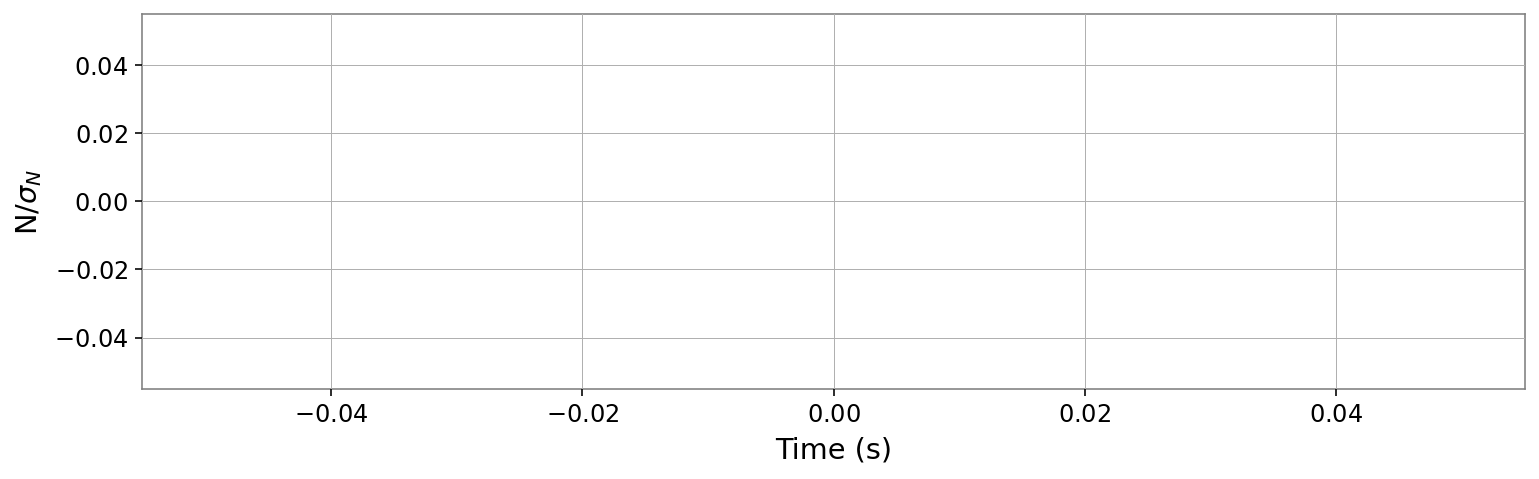

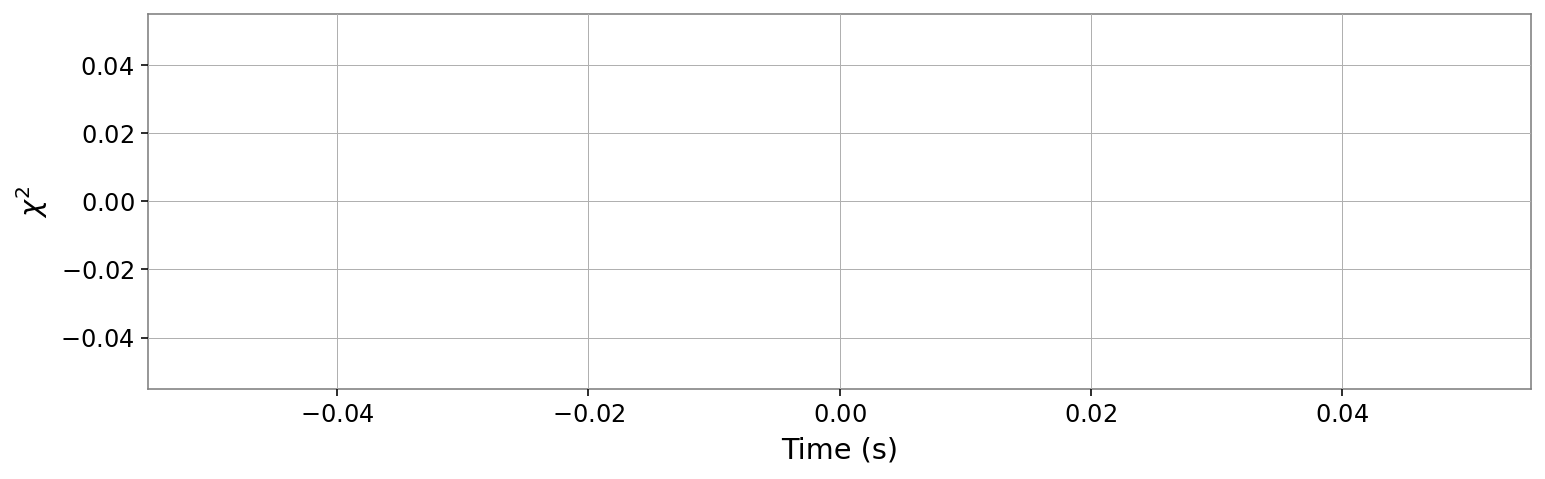

In [ ]:
#>>>PROBLEM
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

print('Develop a machinery to search for GW events across a long time range.')
print('Use the variable white_data_bp, which we created before by whitening and bandpassing')

print(white_data_bp)

times = []
sigs = [] # find significance as a function of time
chi2 = [] # find chi^2 as a function of time


# Develop search function here


plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(times, sigs)
plt.xlabel('Time (s)')
plt.ylabel('N/$\sigma_{N}$')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(times, chi2)
plt.xlabel('Time (s)')
plt.ylabel('$\chi^{2}$')
plt.show()

#**Project Solution**


***Explain your above code:***






***Describe your results:***




<a name='section_1_6'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">PROJ1.6 Exploring Correlation and Time-Delay between Detectors</h2>    

| [Top](#section_1_0) | [Previous Section](#section_1_5) | [Checkpoints](#problems_1_6) |


<h3>Overview</h3>

Next, we can try to analyze data through multiple detector streams. Recall that LIGO employs various detectors (Hanford-H1, Livingston-L1, Virgo-V1) to decrease their false positive rate and identify the region in the sky where the GW arrives from. This can be useful to alert the multimessenger astronomy community of an interesting event - think when Binary Neutron Star (BNS) merger [GW-170817](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.161101) was successfully detected by LIGO and allowed observatories in various EM-wavelengths to point their telescopes at the event, allowing for experimental evidence of the creation of heavy-metals whose origin was previously a mystery. Since detectors are located thousands of miles from each other, the only seemingly correlated signal between each should be a GW.

In this section, we will correlate the signals from H1, L1, and V1 from [GW200129_065458](https://www.gw-openscience.org/eventapi/html/GWTC-3-confident/GW200129_065458/v1). First, read in the data and perform the normal bandpassing and whitening:

[Errno 17] File exists: 'PROJ1'


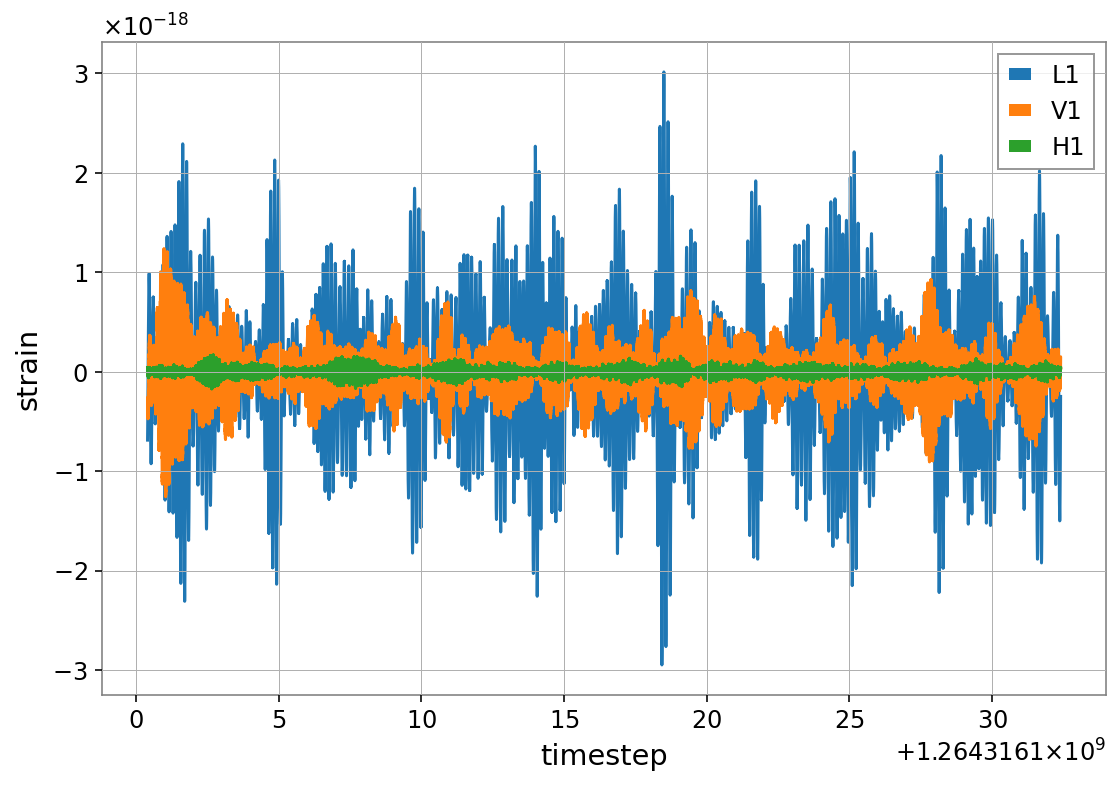

In [ ]:
#>>>RUN

try: 
    os.mkdir('PROJ1') 
except OSError as error: 
    print(error)

# Download data
wget.download('https://www.gw-openscience.org/eventapi/html/GWTC-3-confident/GW200129_065458/v1/H-H1_GWOSC_4KHZ_R1-1264314069-4096.hdf5', 'PROJ1')
wget.download('https://www.gw-openscience.org/eventapi/html/GWTC-3-confident/GW200129_065458/v1/L-L1_GWOSC_4KHZ_R1-1264314069-4096.hdf5', 'PROJ1')
wget.download('https://www.gw-openscience.org/eventapi/html/GWTC-3-confident/GW200129_065458/v1/V-V1_GWOSC_4KHZ_R1-1264314069-4096.hdf5', 'PROJ1')


# Read in data
fn_H1 = 'PROJ1/H-H1_GWOSC_4KHZ_R1-1264314069-4096.hdf5' # data file
fn_L1 = 'PROJ1/L-L1_GWOSC_4KHZ_R1-1264314069-4096.hdf5' # data file
fn_V1 = 'PROJ1/V-V1_GWOSC_4KHZ_R1-1264314069-4096.hdf5'
tevent = 1264316116.4 # Mon Sep 14 09:50:45 GMT 2015
evtname = 'GW200129_065458' # event name

strain_H1 = TimeSeries.read(fn_H1, format='hdf5.gwosc')
strain_L1 = TimeSeries.read(fn_L1, format='hdf5.gwosc')
strain_V1 = TimeSeries.read(fn_V1, format='hdf5.gwosc')
center = tevent
strain_H1 = strain_H1.crop(center-16, center+16)
strain_L1 = strain_L1.crop(center-16, center+16)
strain_V1 = strain_V1.crop(center-16, center+16)


# Compare strains
plt.figure()
plt.plot(strain_L1, label='L1')
plt.plot(strain_V1, label='V1')
plt.plot(strain_H1, label='H1')

plt.legend()
plt.ylabel('strain')
plt.xlabel('timestep')
plt.show()

As we can see, the strain magnitudes look very different between all three detectors! It's almost impossible to build three perfectly identical detectors thousands of miles from each other. However, we can still correlated signals between them. Let's continue our normal preprocessing techniques: whitening and bandpass. As we can see in the bottom plot, there is a noticable difference between the L1 and H1 streams (identically built detectors).

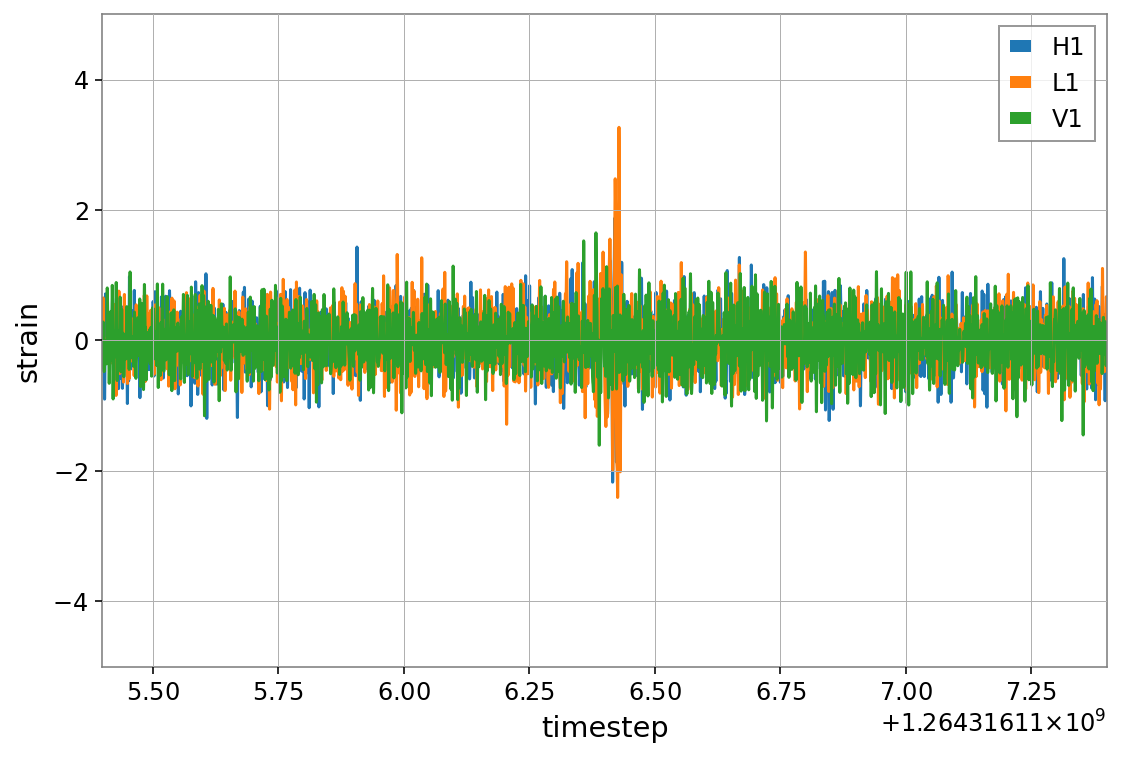

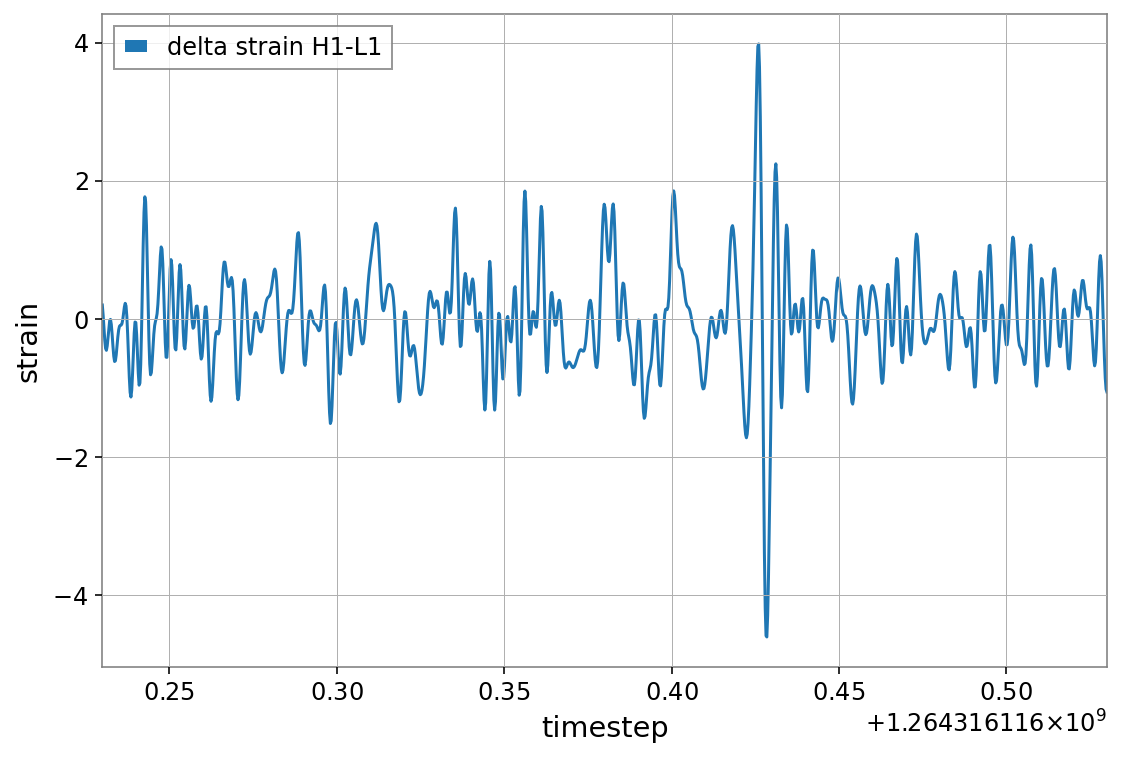

In [ ]:
#>>>RUN

# Preprocess data

# Remember you defined bandpass_low and bandpass_high above 
bandpass_low = 30
bandpass_high = 400

white_data_H1 = strain_H1.whiten()
white_data_L1 = strain_L1.whiten()
white_data_V1 = strain_V1.whiten()
white_data_H1_bp = white_data_H1.bandpass(bandpass_low, bandpass_high) 
white_data_L1_bp = white_data_L1.bandpass(bandpass_low, bandpass_high)
white_data_V1_bp = white_data_V1.bandpass(bandpass_low, bandpass_high)

# Side note: These bandpass frequencies are okay for high mass black hole 
# mergers (like the ones analyzed here), but smaller mass mergers like neutron 
# stars can arrive at frequencies up to 2 KHz! 

plt.figure()
plt.plot(white_data_H1_bp, label='H1')
plt.plot(white_data_L1_bp, label='L1')
plt.plot(white_data_V1_bp, label='V1')

plt.legend()
plt.ylabel('strain')
plt.xlabel('timestep')
plt.ylim(-5, 5)
plt.xlim(tevent-1, tevent+1)
plt.show()

plt.figure()
delta = white_data_H1_bp - white_data_L1_bp
plt.plot(delta, label='delta strain H1-L1')
plt.legend(loc='upper left')
plt.ylabel('strain')
plt.xlabel('timestep')
plt.xlim(tevent-0.17, tevent+0.13)
plt.show()

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Checkpoint 1.6.1</span>

Now we can correlate signals across the multiple detectors. Correlation is done by detrending the input and compared detector strain and then outputting normalized SNRs as number of standard deviations from the expected mean. NOTE: this is a correlation test that LIGO uses to announce GW detections by comparing datastreams to GW-templates (matched-filtering) but we are using it for a bit of a different reason.

Your goal in this checkpoint is to develop the machinery to correlate signals between detectors by taking a dot product in fourier space as you did with the car horn in HW2. This will give you an SNR (try plotting it!) which you can then use to find the offset signal between detectors.

HINT: Ignore timeshifts that are unphysical (taking longer than the max speed of light travel between detectors). 


In [17]:
#>>>PROBLEM

print('# [Hidden code]: develop a function offset(detector1_strain, detector2_strain) which returns the number of steps and time which two strains are offset')

def offset(detector1, detector2):
    
    '''define code here'''
    # Make sure to plot SNR vs Time and view it
    
    return(shiftSteps, shiftTime)


shiftStepsH1L1, shiftTimeH1L1 = offset(white_data_L1_bp, white_data_H1_bp)
print('Number of steps shifted from H1 to L1: %s'%(str(shiftStepsH1L1)))
print('Time shifted from H1 to L1: %s'%str(shiftTimeH1L1))

shiftStepsH1V1, shiftTimeH1V1 = offset(white_data_H1_bp, white_data_V1_bp)
print('Number of steps shifted from H1 to V1: %s'%str(shiftStepsH1V1))
print('Time shifted from V1 to H1: %s'%str(shiftTimeH1V1))

shiftStepsL1V1, shiftTimeL1V1 = offset(white_data_L1_bp, white_data_V1_bp)
print('Number of steps shifted from V1 to L1: %s'%str(shiftStepsL1V1))
print('Time shifted from V1 to L1: %s'%str(shiftTimeL1V1))


Run the cell below to plot the shift-corrected strains on the same plot.

In [18]:
#>>>RUN

# Shift detector strains

# The timeseries.shift(delta) function will simply shift the X-axis (time) forward by the specified delta
shifted_data_H1 = white_data_H1_bp.copy()
shifted_data_H1.shift(shiftTimeH1L1)
shifted_data_H1 *= -1 

shifted_data_V1 = white_data_V1_bp.copy()
shifted_data_V1.shift(shiftTimeL1V1)
shifted_data_V1 *= -1

plt.figure()
plt.plot(white_data_L1_bp, label='L1')
plt.plot(shifted_data_H1, label='H1')
plt.plot(shifted_data_V1, label='V1')
plt.legend()
plt.ylabel('strain')
plt.xlim(tevent-0.07, tevent+0.07)
plt.title('Corrected-Shifted Strain')
plt.show()

It looks like the strains are aligning well! Next, we can calculate the region in the sky where this GW resides given the offsets between detectors. Think of the GW as some farfield source whose wave creates a right triangle between two detectors. This will give you a region in space where the GW originates from which can then be used to alert multi-messenger astronomy (MMA) pipelines. 

What you need to do: Calculate (using simple trigonometry) the projected angles in the direction of:

    L1 to H1 (3000 km)
    H1 to V1 (8166 km)
    L1 to V1 (8868 km)

In [ ]:
#>>>PROBLEM

DistanceL1H1 = 3000 #km
DistanceH1V1 = 8166 #km
DistanceL1V1 = 8868 #km
c = 3e5 # Speed of light in Km/s

# Calculate (using simple trigonometry) the cone where the GW 
# resides in the sky for each detector pair

AngleL1H1 = 
AngleH1V1 = 
AngleL1V1 = 

print('Angle in sky from L1 towards H1: %s degrees'%(AngleL1H1))
print('Angle in sky from H1 towards V1: %s degrees'%(AngleH1V1))
print('Angle in sky from L1 towards V1: %s degrees'%(AngleL1V1))


#**Project Solution**

***Explain your above code:***



***Describe your results:***
